# Système de filtrage collaboratif

Le but de ce notebook est de mettre en place un système de recommandation pour des restaurants en utilisant la méthode du **filtrage collaboratif**. La structure générale d'un système de recommandation est qu'il y a des utilisateurs et des items.

Les utilisateurs expriment des préférences explicites ou implicites relativent à certains items. Le filtrage collaboratif repose donc sur le comportement passé de l'utilisateur.

Il y a deux approches au filtrage collaboratif: les méthodes de voisinage et les modèles d'analyse factorielle.

Les méthodes de voisinage calculent les relations entre les items ou entre les utilisateurs.
L'analyse factorielle utilise des modèles de facteurs cachés au travers desquels les utilisateurs et les items sont transposés dans un même espace. Par exemple, si on est en train de noter des films, on peut transformer les items en des facteurs de genre et les utilisateurs en des préférences pour un genre particulier.

Les modèles d'analyse factorielle amènent généralement à des moteurs de recommandation plus pertinent. Une des raisons qui explique cela est la parcimonie des matrices utilisateur-item. La plupart des utilisateurs ne note que un ou deux items tout au plus. Les modèles d'analyse factorielle sont plus coûteux et prennent en compte moins de paramètres. Cependant, les modèles de voisinage sont plus utilisés car ils sont plus intuitifs (si tu as aimé ça, tu aimeras ça) et sont plus adaptables car une nouvelle préférence peut être ajouté très rapidement.

La plupart des systèmes de recommandation de nos jours combine du filtrage collaboratif par voisinage, du FC avec modèle et de la décomposition en valeurs singulières pour factoriser les matrices.

### Approches par utilisateur et item

Les approches originales au filtrage collaboratif par voisinage utilisent des modèles utilisateur-utilisateur. Ce qui signifie que les notes estimées sont faites à partir des notes données par des utilisateurs au profil similaire. Cependant, étant donné que la plupart des utilisateurs ne notent que très peu d'items, les moteurs de recommandation basés sur des préférences explicites ne sont pas efficaces. Cette situation implique que la plupart des systèmes fondés sur des méthodes de voisinage tel qu'Amazon utilise des approches dites item-item. Dans ces méthodes, une note est estimée par d'autres notes attribuées par l'utilisateur à des items similaire ou voisin, il s'agit donc de l'algorithme des K voisins les plus proches.

### Construction de notre système

Notre travail va se présenter comme suit:

1) Créer une base de donnée de similarité entre pair d'items. Utiliser cette dernière pour implémenter un système de recommandation à base de filtrage collaboratif (neighborhood based) capable de répondre à une question simple comme "donne moi plus de restaurant comme celui là". Cette première étape suppose que les similarités calculées produisent de bonne recommandation globale.

2) Dans cette seconde étape, on va aller un peu plus loin en tentant de prédire la note qu'un utilisateur va donner à un item qu'il n'a jamais vu auparavant. Cela nécessite que l'on trouve les restaurants que l'utilisateur va noté de façon similaire (pas que ceux qui sont globalement similaire).

3) On implémente un système de recommandation à base de filtrage collaboratif (factor-based) utilisant un modèle bayésien. Même si c'est un peu plus complexe, ceci va nous permettre d'extraire des informations à propos d'utilisateurs similaires et de restaurants similaires.

4) On va *scale* notre système en créant un système de recommandation comme dans l'étape 1 et 2 mais qui fonctionne sur tout le dataset. On va utiliser pour cela MapReduce pour distribuer le calcul sur plusieurs machines.

On va commencer par travailler sur une partie des données des restaurant pour ensuite généraliser à tout le dataset à l'étape 4. Le dataset complet contient 150000 critiques, mais on va commencer avec 7000 seulement. On va créer ce dataset partiel en prenant tous les utilisateurs qui ont noté plus de 60 restaurants et tous les restaurants qui ont reçu plus de 150 critiques. Ce n'est pas un dataset aléatoire car on utilise un dataset plus accommodant étant donné qu'il est plus parcimonieux que le dataset complet.

In [1]:
%matplotlib inline

from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

## Description du dataset

Le dataset a été extrait depuis l'annuaire Yelp qui répertorie des milliers de restaurant. Il est disponible [ici](https://dl.dropboxusercontent.com/u/75194/bigdf.csv).

In [2]:
fulldf=pd.read_csv("bigdf.csv")
fulldf.head(4)

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,5,Jason,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.796954,197
1,SBbftLzfYYKItOMFwOTIJg,9yKzy9PApeiPPOUJEtnvkg,2008-05-04 00:00:00,DASdFe-g0BgfN9J2tanStg,5,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.473684,57
2,mlBC3pN9GXlUUfQi1qBBZA,9yKzy9PApeiPPOUJEtnvkg,2010-07-05 00:00:00,W8CX2h_hmODWmgSJVbMifw,2,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.702381,84
3,0bNXP9quoJEgyVZu9ipGgQ,9yKzy9PApeiPPOUJEtnvkg,2012-10-10 00:00:00,nYVQiPGeiwr7g5BSX7WDJg,3,9,Aileen,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.180077,261


Le data frame est un tableau de critiques. On a joint les informations à propos des utilisateurs et des restaurants dans ce tableau.

**On dispose d'information sur les critiques :**

*'stars': (star rating, integer 1-5), 'date': (date, formatted like '2011-04-19'), 'review_id': (unique id for the review).*

**Voici la description des champs de ce dataframe pour les restaurants :**

*'business_id': (a unique identifier for this business), 'biz_name': (the full business name), 'latitude': (latitude), 'longitude': (longitude), 'business_review_count': (review count for the restaurant[this is a repeated field for all reviews of the restaurant]), 'categories': [(localized category names)], 'business_avg': (average stars over all users reviews for business[this is a repeated field for all reviews of the restaurant]).*

**Et pour les champs utilisateurs :**

*'user_id': (unique user identifier), 'user_name': (first name, last initial, like 'Matt J.'), 'user_review_count': (count of restaurants reviewed by user[this is a repeated field for all reviews by the user]), 'user_avg': (floating point average of users reviews over all businesses, like 4.31[this is a repeated field for all reviews by the user]).*

Dans ce dataset, chaque utilisateur n'a qu'une seule critique pour chaque restaurant.

## Notre système de recommandation

Pour expliquer notre système de recommandation, on vous propose l'exemple suivant. Imaginons qu'on est à Lyon et que la note moyenne des restaurants là bas est de 3,5. Le Dumel situé Place Guichard est meilleur qu'un restaurant moyen donc il est amené à être noté 0,5 étoiles de plus que la moyenne (pour tous les utilisateurs). Cependant, vous êtes un utilisateur difficile, qui tend à noté 0,2 étoiles de moins que la moyenne. Donc une estimation de base pour la recommandation de Le Dumel, pour vous, est 3,5 + 0,5 - 0,2 = 3,8.

Ces estimations de bases ajuste les données en prenant en compte les tendances systématiques de certains utilisateurs qui donne de meilleurs notes que d'autres et des restaurants qui reçoivent des notes plus élevés que d'autres. On peut écrire une estimation de base (baseline) $\hat Y_{um}^{baseline}$ pour une note inconnue $Y_{um}$, pour un utilisateur $u$ et un restaurant $m$ tel que :

$$ \hat Y_{um}^{baseline} = \hat \mu + \hat \theta_{u0} + \hat \gamma_{m0} $$

où les paramètres inconnus $\theta_{u0}$ et $\gamma_{m0}$ indiquent le biais de l'utilisateur $u$ et du restaurant $m$, respectivement, par rapport à un paramètre d'interception $\mu$. (Nous expliquerons dans l'étape 3 la notation 0) 

Remarquez que $\theta_{u0}$ et $\gamma_{m0}$ sont des paramètres qui nécessitent d'être ajuster ("fitter"). Pour commencer simplement dans les étapes 1 et 2, on va remplacer ces deux paramètres par leur estimation "moyenne" à partir des données. D'où :

$$ \hat Y^{baseline}_{um} = \bar Y + (\bar Y_u - \bar Y) + (\bar Y_m - \bar Y)$$

où $\bar Y_u$ =  `user_avg`, la moyenne de toutes les notes des utilisateurs $u$ et $\bar Y_m$ = `business_avg`, la moyenne de toutes les notes pour un restaurant $m$. $\bar Y$ est la note moyenne de toutes les critiques.

Les deux derniers termes correpondent aux biais des notes qui sont spécifiques aux utilisateurs et aux restaurants, ils montrent comment leurs notes tendent à diverger systématiquement de la moyenne générale. Il s'agit de la façon la plus simple pour prédire une note en se basant uniquement sur les informations à propos d'un utilisateur et d'un restaurant.

Peut-on faire une meilleur prédiction pour la note $Y_{um}$ que l'utilisateur $u$ va donner au restaurant $m$ ? Selon les principes du filtrage collaboratif, nous devrions être capable d'utiliser les réponses d'utilisateurs *similaires* à propos de restaurants *similaires* pour obtenir une meilleur prédiction.

On peut faire une estimation de $Y_{um}$ tel que:

$$ \hat Y_{um} = \hat Y_{um}^{baseline}\, + \,\frac{\sum\limits_{j \in S^{k}(m)} s_{mj} ( Y_{uj} - \hat Y_{uj}^{baseline} )}{\sum\limits_{j \in S^{k}(m)} s_{mj} } $$

où $s^{k}(m)$ est le $k$ voisins restaurants du restaurant $m$ basé sur un critère de pooling, par exemple, les restaurants qui ont été noté par l'utilisateur $u$.

Dans les deux prochaines étapes, on va se concentrer sur l'utilisation de restaurants similaires, ou de restaurants dans le voisinage du cluster. 
Afin de faire cela, on va calculer une *mesure de similarité* $s_{mj}$ entre le $m$-ième et le $j$-ième restaurants. Cette similarité peut être mesuré via une [similarité cosinus](http://fr.wikipedia.org/wiki/Similarit%C3%A9_cosinus), [Coefficient de corrélation linéaire de Bravais-Pearson](http://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) ou en utilisant une autre mesure de distance. Dans notre cas, on va utiliser le coefficient de corrélation linéaire de Pearson. Cela mesure la tendance qu'ont les utilisateurs à noté un restaurant de façon similaire. Etant donnée que la plupart des notes sont inconnues, on va calculer le "common user support" (`n_common`), qui est le set des utilisateurs ayant noté les deux restaurants.

Dans la première partie, on va définir $S$ comme le voisinage global d'un restaurant, dans la seconde partie on va le définir comme l'ensemble des restaurants qui ont été noté par l'utilisateur $u$.

## I. Développement d'un système de recommandation "globale" simple

Maintenant que l'on dispose d'une façon de mettre en commun les informations entre restaurants similaires pour essayer de prédire la recommandation pour un utilisateur, on va réfléchir au choix du voisinage à utiliser pour récupérer ces informations. On commence par le choix le plus simple. On calcule la similarité entre restaurants en utilisant tout leur "common user support", puis on classe les plus proches voisins d'un restaurant à l'aide de cette similarité. On appelle cela un système de recommandation "globale" car il suppose que tous les utilisateurs perçoivent la similarité entre les restaurants de la même façon. Plus tard, on implémentera un système de recommandation plus spécifique qui met en commun les informations en se basant sur quel restaurant semble le plus similaire à cet utilisateur.

Une système de recommandation globale à l'avantage de pouvoir gérer la possible parcimonie des restaurants notés par l'utilisateur, mais aussi l'inconvénient de donner une réponse pour tous les utilisateurs sans prendre en compte les préférences d'un utilisateur précis. Il s'agit d'un cas classique où il faut choisir entre favoriser le biais ou la variance.

Implémentons ce système de recommandation globale simple.

### Analyse exploratoire des données

**1.1** On va visualiser la parcimonie de tout le dataset en traçant deux histogrammes du nombre de critiques par utilisateur et par restaurant respectivement.

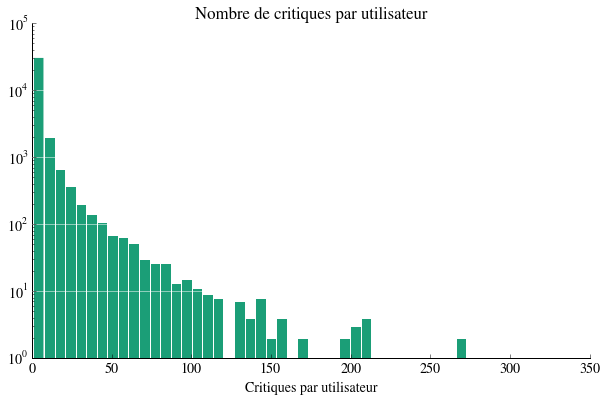

In [3]:
urc=fulldf.groupby('user_id').review_id.count()
ax=urc.hist(bins=50, log=True)
remove_border(ax)
plt.xlabel("Critiques par utilisateur")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Nombre de critiques par utilisateur");

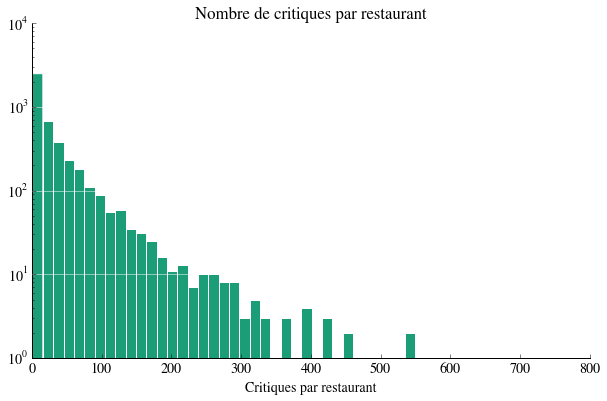

In [4]:
brc=fulldf.groupby('business_id').review_id.count()
ax=brc.hist(bins=50, log=True)
remove_border(ax)
plt.xlabel("Critiques par restaurant")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Nombre de critiques par restaurant");

In [5]:
print "Nombre de critiques", fulldf.shape[0]
print "Nombre d'utilisateurs", fulldf.user_id.unique().shape[0], "Nombre de business", fulldf.business_id.unique().shape[0]

Nombre de critiques 149319
Nombre d'utilisateurs 34789 Nombre de business 4503


On voit qu'il y a plus d'utilisateurs que de restaurant.

Nombre d'etoiles moyen de toutes les critiques: 3.74141268023


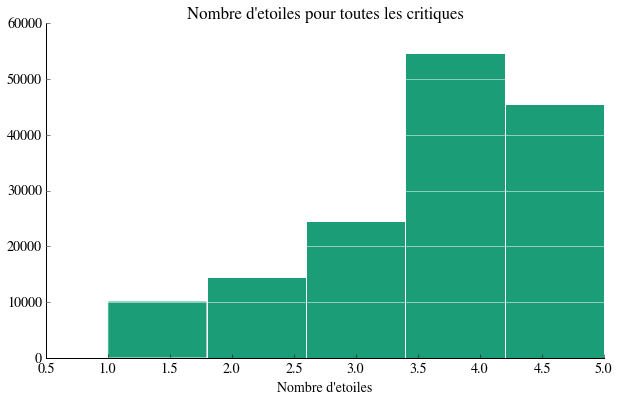

In [6]:
print "Nombre d'etoiles moyen de toutes les critiques:",fulldf.stars.mean()
stars=fulldf.stars
ax=stars.hist(bins=5)
remove_border(ax)
plt.xlabel("Nombre d'etoiles")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Nombre d'etoiles pour toutes les critiques");

La fonction suivant est utilisé pour re-calculer le nombre et la moyenne des critiques lorsqu'on crée un subset de notre dataframe principal. On va utiliser cette fonction pour construire un dataframe plus petit et plus rapide à traiter.

In [7]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('user_id')
    ldfb=ldf.groupby('business_id')
    user_avg=ldfu.stars.mean()
    user_review_count=ldfu.review_id.count()
    business_avg=ldfb.stars.mean()
    business_review_count=ldfb.review_id.count()
    nldf=ldf.copy()
    nldf.set_index(['business_id'], inplace=True)
    nldf['business_avg']=business_avg
    nldf['business_review_count']=business_review_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user_id'], inplace=True)
    nldf['user_avg']=user_avg
    nldf['user_review_count']=user_review_count
    nldf.reset_index(inplace=True)
    return nldf

**1.2** On crée un dataset plus petit dans un dataframe `smalldf` en gardant que les restaurants avec plus de 150 critiques et les utilisateurs ayant réalisé plus de 60 critiques. En incluant toutes les colonnes présentes dans le dataframe original. Etant donnée que nous avons créer un subset de notre dataset, on va utiliser la méthode ci-dessus pour recalculer les moyennes. 

Il faut noter que même si notre subset fait en sorte de contenir des utilisateurs écrivant beaucoup de critiques, les restaurants sélectionnés introduisent la parcimonie en réduisant le nombre de critiques par utilisateur.

In [8]:
smallidf=fulldf[(fulldf.user_review_count > 60) & (fulldf.business_review_count > 150)]
smalldf=recompute_frame(smallidf)

Pour voir comment ce nouveau subset se compare à notre dataset parent en terme de taille et de parcimonie, on va réaliser des histogrammes du nombre de critiques par utilisateur et du nombre de critiques par restaurant.

Nombre Total de Critiques 6165
Nombre d'Utilisateurs dans ce set 240 Restaurants 172


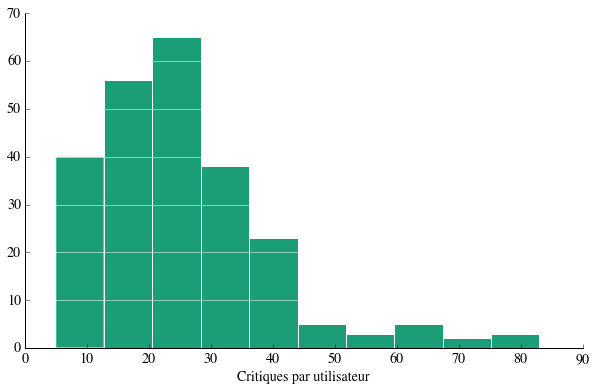

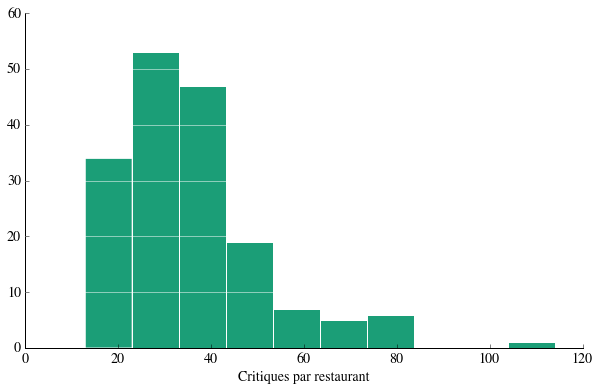

In [9]:
print "Nombre Total de Critiques", smalldf.shape[0]
print "Nombre d'Utilisateurs dans ce set", smalldf.user_id.unique().shape[0], "Restaurants",smalldf.business_id.unique().shape[0]
plt.figure()
ax=smalldf.groupby('user_id').review_id.count().hist()
remove_border(ax)
plt.xlabel("Critiques par utilisateur")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.figure()
ax=smalldf.groupby('business_id').review_id.count().hist()
remove_border(ax)
plt.xlabel("Critiques par restaurant")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')

Etant donnée que nous avons extrait un subset aux caractéristiques très précises, on s'assure que l'on dispose bien des restaurants avec plus de 150 critiques et les utilisateurs ayant fait plus de 60 critiques. Ce dataset n'est pas aussi parcimonieux que le dataset principal, cela se voit dans les deux graphes car l'histogramme ne présente pas une forte décroissance comme vu pour le dataset complet.

**1.3** On va afficher les histogrammes la note moyenne donnée par l'utilisateur et la note moyenne d'un restaurant pour le subset.

3.86763990268


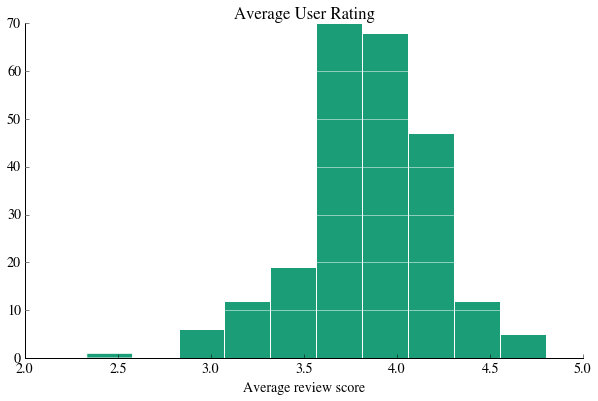

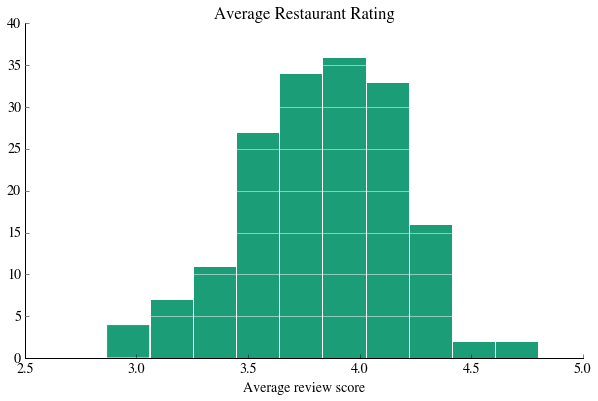

In [10]:
plt.figure()
avg_ratings_by_user=smalldf.groupby('user_id').stars.mean()
ax=avg_ratings_by_user.hist()
remove_border(ax)
plt.xlabel("Average review score")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Average User Rating")
plt.figure()

avg_ratings_by_biz=smalldf.groupby('business_id').stars.mean()
ax=avg_ratings_by_biz.hist()
remove_border(ax)
plt.xlabel("Average review score")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Average Restaurant Rating")
plt.figure()

print smalldf.stars.mean()
plt.figure()

###"Common Support"

On va réaliser maintenant un histogramme du *"common user support"* (le nombre de critiques communes aux utilisateurs) de chaque paire de restaurants dans le subset.

Le "common support" est un concept important car pour chaque paire de restaurants, il s'agit du nombre d'utilisateurs qui ont critiqué les deux. Ce dernier va être utiliser pour modifier la similarité entre les restaurants. Si le "common support" est faible, la similarité est moins crédible.

Mean support is: 6.84679722562


(array([  7.02000000e+03,   4.98700000e+03,   1.79400000e+03,
          5.90000000e+02,   1.95000000e+02,   7.60000000e+01,
          2.20000000e+01,   1.00000000e+01,   1.00000000e+01,
          2.00000000e+00]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ]),
 <a list of 10 Patch objects>)

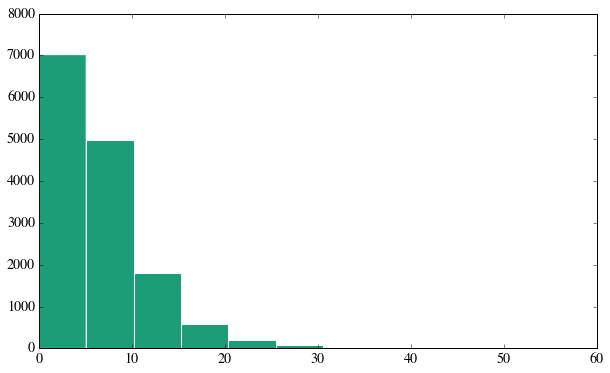

In [11]:
restaurants=smalldf.business_id.unique()
supports=[]
for i,rest1 in enumerate(restaurants):
    for j,rest2 in enumerate(restaurants):
        if  i < j:
            rest1_reviewers = smalldf[smalldf.business_id==rest1].user_id.unique()
            rest2_reviewers = smalldf[smalldf.business_id==rest2].user_id.unique()
            common_reviewers = set(rest1_reviewers).intersection(rest2_reviewers)
            supports.append(len(common_reviewers))
print "Mean support is:",np.mean(supports)
plt.hist(supports)

Comme vous pouvez le voir, même si on a choisi un subset du dataframe dans lequel chaque restaurant a 150 critiques et chaque utilisateur a fait au moins 60 critiques, le "common support" de la plupart des paires de restaurants est très faible, il est inférieur à 10.

### Calculer la similarité

Les utilisateurs notent les restaurants sur une échelles de 1 à 5. Même si cette note est une valeur entière, nous allons la manipuler comme un nombre réel.

Chaque utilisateur utilise la même échelle 5 étoiles quand il note un restaurant, ce qui peut être problématique quand on compare deux utilisateurs par rapport à leurs notes. On considère un utilisateur difficile dont la note moyenne donnée est de 2 et un second utilisateur plus enthousiaste dont la note moyenne donnée est de 4. La question qui peut se poser est comment on va comparer une note de 3 donnée par l'utilisateur difficile à une note de 5 donnée par l'utilisateur enthousiaste.

Pour résoudre ce problème, on doit soustraire la note moyenne donnée par l'utilisateur de la note actuel d'un restaurant quand on calcul la similarité entre deux restaurants. Ceci fait que les notes données par nos deux utilisateurs comparables. Cette opération est réalisé dans la fonction `pearson_sim` définie ci-dessous.

S'il n'y a pas de "common support" (`n_common=0`), on n'a aucun élément pour faire une estimation de la similarité, on va donc fixer la similarité à 0. Dans le cas où la variance de la note d'un restaurant est de 0, comme quand il n'existe qu'un seul utilisateur commun (`n_common=1`), on retourne la valeur `NaN` que scipy renvoi lorsqu'on utilise `pearsonr`. 

In [12]:
from scipy.stats.stats import pearsonr
def pearson_sim(rest1_reviews, rest2_reviews, n_common):
    """
    Given a subframe of restaurant 1 reviews and a subframe of restaurant 2 reviews,
    where the reviewers are those who have reviewed both restaurants, return 
    the pearson correlation coefficient between the user average subtracted ratings.
    The case for zero common reviewers is handled separately. Its
    ok to return a NaN if any of the individual variances are 0.
    """
    if n_common==0:
        rho=0.
    else:
        diff1=rest1_reviews['stars']-rest1_reviews['user_avg']
        diff2=rest2_reviews['stars']-rest2_reviews['user_avg']
        rho=pearsonr(diff1, diff2)[0]
    return rho

La fonction `get_restaurant_reviews` définie plus bas prend un restaurant `business_id` et un groupe d'utilisateurs, puis retourne les critiques pour ce restaurant de ce groupe d'utilisateurs.

In [13]:
def get_restaurant_reviews(restaurant_id, df, set_of_users):
    """
    given a resturant id and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.user_id.isin(set_of_users)) & (df.business_id==restaurant_id)
    reviews = df[mask]
    reviews = reviews[reviews.user_id.duplicated()==False]
    return reviews

**1.4** Nous allons écrire une fonction `calculate_similarity` qui calcule la similarité entre deux restaurants en prenant un dataframe et une fonction de similarité `similarity_func`. Un exemple de fonction de similarité peut être la fonction `pearson_sim` définie plus haut. `calculate_similarity` opère comme suit :

1. Pour chacun des deux restaurants, on récupère la liste des utilisateurs ayant réalisé une critique pour ce restaurant et on calcule l'intersection entre ces deux sets. On calcule aussi le nombre de critiques communs `n_common`.

2. On utilise la fonction `get_restaurant_reviews` définie plus bas pour obtenir les critiques de chaque restaurant tel que réaliser par ces utilisateurs semblables. On remarque que `get_restaurant_reviews` retourne un nouveau dataframe avec les critiques.

3. On calcul la similarity en utilisant `similarity_func` qui prend en entrée les deux dataframes de critiques de la partie 2 et le nombre d'utilisateurs communs `n_common`.

4. Retourner la similarité et le `n_common` dans un tuple `(sim, n_common)`. Si la similarité est un `NaN`, on fait en sorte que la similarité est égale à 0.

In [14]:
"""
Function
--------
calculate_similarity

Parameters
----------
rest1 : string
    The id of restaurant 1
rest2 : string
    The id of restaurant 2
df : DataFrame
  A dataframe of reviews, such as the smalldf above
similarity_func : func
  A function like pearson_sim above which takes two dataframes of individual
  restaurant reviews made by a common set of reviewers, and the number of
  common reviews. This function returns the similarity of the two restaurants
  based on the common reviews.
  
Returns
--------
A tuple
  The first element of the tuple is the similarity and the second the
  common support n_common. If the similarity is a NaN, set it to 0
"""
#your code here
def calculate_similarity(rest1, rest2, df, similarity_func):
    # find common reviewers
    rest1_reviewers = df[df.business_id==rest1].user_id.unique()
    rest2_reviewers = df[df.business_id==rest2].user_id.unique()
    common_reviewers = set(rest1_reviewers).intersection(rest2_reviewers)
    n_common=len(common_reviewers)
    #get reviews
    rest1_reviews = get_restaurant_reviews(rest1, df, common_reviewers)
    rest2_reviews = get_restaurant_reviews(rest2, df, common_reviewers)
    sim=similarity_func(rest1_reviews, rest2_reviews, n_common)
    if np.isnan(sim):
        return 0, n_common
    return sim, n_common

### Construire une base de données de similarité

On passe maintenant au calcul d'une base de données globale de paires de restaurants similaires.
La fonction qui suit permet de réaliser cette base de données de similarités pour chaque paire de restaurants de la BDD. La classe `Database` est initialisé par son constructeur en prenant pour argument une dataframe de critiques. La méthode `populate_by calculating` itère sur chaque paire possible de business_id dans le dataframe et remplit la BDD avec les similiratés et les "common supports". Cette méthode prend pour argument la fonction de similarité `similarity_func` tel que `pearson_sim` (ensuite `calculate_similarity` utilise ça pour calculer la similarité). La méthode `get` permet de récupérer depuis la BDD la similarité pour deux business_id.

In [15]:
class Database:
    "A class representing a database of similaries and common supports"
    
    def __init__(self, df):
        "the constructor, takes a reviews dataframe like smalldf as its argument"
        database={}
        self.df=df
        self.uniquebizids={v:k for (k,v) in enumerate(df.business_id.unique())}
        keys=self.uniquebizids.keys()
        l_keys=len(keys)
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)
        
    def populate_by_calculating(self, similarity_func):
        """
        a populator for every pair of businesses in df. takes similarity_func like
        pearson_sim as argument
        """
        items=self.uniquebizids.items()
        for b1, i1 in items:
            for b2, i2 in items:
                if i1 < i2:
                    sim, nsup=calculate_similarity(b1, b2, self.df, similarity_func)
                    self.database_sim[i1][i2]=sim
                    self.database_sim[i2][i1]=sim
                    self.database_sup[i1][i2]=nsup
                    self.database_sup[i2][i1]=nsup
                elif i1==i2:
                    nsup=self.df[self.df.business_id==b1].user_id.count()
                    self.database_sim[i1][i1]=1.
                    self.database_sup[i1][i1]=nsup
                    

    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.uniquebizids[b1]][self.uniquebizids[b2]]
        nsup=self.database_sup[self.uniquebizids[b1]][self.uniquebizids[b2]]
        return (sim, nsup)

On fait tourner `make_database` et on enregistre le résultat dans variable globale `db`. On va présenter un exemple ci-dessous (cela peut prendre un peu de temps).

In [16]:
db=Database(smalldf)
db.populate_by_calculating(pearson_sim)

In [69]:
db.get("z3yFuLVrmH-3RJruPEMYKw", "zruUQvFySeXyEd7_rQixBg")

(0.39904554525734559, 7)

### K-plus proches restaurants (en similarité)

On va maintenant trouver les k-plus proches restaurants vis à vis d'un restaurant précis en se basant sur la BDD de similarités que l'on a construit. Cependant, un problème apparait.

Considérons les deux cas où il y a uniquement un seul utilisateur commun et quand il y a 40. Dans le premier cas, on peut obtenir une similarité artificiellement élevée en se basant sur les goûts de ce seul utilisateur, ce qui nous amène à réduire son importance dans le calcul du plus proche voisin. Dans le second cas, on va obtenir un estimateur de similarité des deux restaurants bien moins biaisé.

Pour contrôler les effets de "common supports" faible, on peut **réduire** les coefficients de pearson. On peut réaliser ça en utilisant le paramètre de "régularisation" `reg` :

$$s_{mj} = \frac{N_{common}\, \rho_{mj}}{N_{common}+reg} $$

où $N_{common}$ (`n_common`) est le "common reviewer support" et $\rho_{ij}$ est le coefficient de correlation de pearson.

On souhaite réduire la variance dans nos estimations, on déplace donc nos estimations en direction d'un point précis de façon à  fortement concentrer nos estimations quand il y a peu de données.

Une bonne valeur du paramètre de "régularisation" est intuitivement une qui n'affecte pas la similarité quand le "common support" est élevé ~ 10, mais qui a de l'importance losque le support est faible. Dans ce cas, des valeurs entre 2 et 4 sont bonnes. Habituellement, la valeur de `reg` est déterminé en utilisant une cross-validation mais pour faire simple, on va utilisé un `reg` = 3.

On définie une fonction `shrunk_sim` qui prend la `sim` et le `n_common` obtenus depuis la BDD, puis réduit la similarité en utilisant le paramètre de régularisation `reg`.

In [70]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

**1.5** On écrit maintenant une fonction `knearest` qui trouve les `k` plus proches voisins d'un restaurant en se basant sur la similarité réduite que l'on a calculé. Il faut noter que comme défini ici, les plus proches voisins sont communs sur le set entier de restaurants et ne sont pas restreint aux restaurants que l'utilisateur a critiqué (chose que l'on va faire par la suite). Ce qui fait que cette fonction est très coûteuse en temps de calcul.

La fonction `knearest` qui retourne une *k-length sorted list* de 3-tuples chacune correspondant à un restaurant. La structure du tuple est `(business_id, shrunken similarity score, common support)` où le score de similarité et le "common support" sont spécifiques au restaurant dont on trouve les voisins, et le `business_id` est l'id du restaurant le plus proche que l'on trouve. Les restaurants les plus proches sont trouvés dans un array numpy de restaurants `set_of_restaurants`. 

In [71]:
"""
Function
--------
knearest

Parameters
----------
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
set_of_restaurants : array
    The set of restaurants from which we want to find the nearest neighbors
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top k similar restaurants. The list is a list of tuples
    (business_id, shrunken similarity, common support).
"""
#your code here
from operator import itemgetter
def knearest(restaurant_id, set_of_restaurants, dbase, k=7, reg=3.):
    """
    Given a restaurant_id, dataframe, and database, get a sorted list of the
    k most similar restaurants from the entire database.
    """
    similars=[]
    for other_rest_id in set_of_restaurants:
        if other_rest_id!=restaurant_id:
            sim, nc=dbase.get(restaurant_id, other_rest_id)
            ssim=shrunk_sim(sim, nc, reg=reg)
            similars.append((other_rest_id, ssim, nc ))
    similars=sorted(similars, key=itemgetter(1), reverse=True)
    return similars[0:k]

### On passe à la recommandation

On va choisir deux restaurants très différents dans le dataframe.

In [72]:
testbizid="eIxSLxzIlfExI6vgAbn2JA"
testbizid2="L-uPZxooP_ziXCtRrWi8Pw"

On écrit des fonctions qui permettent de trouver le nom d'un restaurant à partir de sa business_id, ainsi que le nom d'utilisateur à partir de la user_id.

In [73]:
def biznamefromid(df, theid):
    return df['biz_name'][df['business_id']==theid].values[0]
def usernamefromid(df, theid):
    return df['user_name'][df['user_id']==theid].values[0]

In [74]:
print testbizid, biznamefromid(smalldf,testbizid)
print testbizid2, biznamefromid(smalldf, testbizid2)

eIxSLxzIlfExI6vgAbn2JA Lobbys Beef Burgers Dogs
L-uPZxooP_ziXCtRrWi8Pw Café Monarch


#### On récupère les meilleurs recommandations

Il est temps de répondre à la question : "si vous avez aimé ceci, vous allez aimer ça". On utilise nos deux business_ids pour calculer les `k=7` plus proches voinsins avec une "régularisation" de `3.`. On affiche ensuite les 7 meilleurs recommandations avec leur coefficient de similarité et leur "common support".

In [75]:
tops=knearest(testbizid, smalldf.business_id.unique(), db, k=7, reg=3.)
print "Pour ",biznamefromid(smalldf, testbizid), ", les meilleurs correspondances sont:"
for i, (biz_id, sim, nc) in enumerate(tops):
    print i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc

Pour  Lobbys Beef Burgers Dogs , les meilleurs correspondances sont:
0 La Condesa Gourmet Taco Shop | Sim 0.598714448434 | Support 6
1 Citizen Public House | Sim 0.571428571429 | Support 4
2 FnB | Sim 0.527129890943 | Support 5
3 Defalco's Italian Grocery | Sim 0.519456555658 | Support 6
4 Republic Ramen + Noodles | Sim 0.519140146937 | Support 5
5 unPhogettable | Sim 0.5 | Support 3
6 Haus Murphy's | Sim 0.467637235308 | Support 3


In [76]:
tops2=knearest(testbizid2, smalldf.business_id.unique(), db, k=7, reg=3.)
print "Pour ",biznamefromid(smalldf, testbizid2), ", les meilleurs correspondances sont:"
for i, (biz_id, sim, nc) in enumerate(tops2):
    print i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc

Pour  Café Monarch , les meilleurs correspondances sont:
0 Postino Arcadia | Sim 0.625 | Support 5
1 The Main Ingredient Ale House And Café | Sim 0.571428571429 | Support 4
2 Brio Tuscan Grille | Sim 0.571428571429 | Support 4
3 Kazimierz World Wine Bar | Sim 0.5 | Support 3
4 Harlow's Cafe | Sim 0.5 | Support 3
5 The Fry Bread House | Sim 0.5 | Support 3
6 Cien Agaves Tacos & Tequila | Sim 0.5 | Support 3


On peut voir clairement que ces deux restaurants ont complétement rien à voir entre eux.

Une seconde question se pose : quelles sont les meilleurs recommandations pour un utilisateur ? Pour répondre à cette question, on doit trouver les restaurants les mieux notés par cet utilisateur, puis trouver les plus proches voisins de ces restaurants, fusionner les deux listes tout en supprimant les doublons et les restaurants que l'utilisateur a déjà noté, et enfin classer les restaurants en fonction de leur note moyenne. Voici le code pour obtenir les restaurants préférés d'un utilisateur dans un dataframe.

In [77]:
def get_user_top_choices(user_id, df, numchoices=5):
    "recuperer le top 5 des restaurants pour un utilisateur trie par le nombre d'etoiles qui leur a donne"
    udf=df[df.user_id==user_id][['business_id','stars']].sort(['stars'], ascending=False).head(numchoices)
    return udf
testuserid="7cR92zkDv4W3kqzii6axvg"
print "Pour l'utilisateur", usernamefromid(smalldf,testuserid), "les meilleurs correspondances sont:" 
bizs=get_user_top_choices(testuserid, smalldf)['business_id'].values
[biznamefromid(smalldf, biz_id) for biz_id in bizs]

Pour l'utilisateur Vern les meilleurs correspondances sont:


['Tee Pee Mexican Food',
 'Local Breeze',
 "Carly's Bistro",
 'District American Kitchen and Wine Bar',
 'Sonora Mesquite Grill']

#### On récupère les meilleurs recommandations pour un utilisateur

**1.6** On écrit une fonction `get_top_recos_for_user` qui prend en argument le `userid`, les `n` restaurants préférés de l'utilisateur, le dataframe, `k`, et enfin le paramètre de "régularisation". La fonction retourne les meilleurs recommandations obtenues en combinant les restaurants voisins de chacun des `n` choix, comme décrit dans le paragraphe précédent. Ceci retourne une liste de tuples `(restaurant_id, business_avg)` triée par `business_avg` où `business_avg` est la moyenne des notes d'un restaurant sur tout le dataframe.

In [78]:
"""
Function
--------
get_top_recos_for_user

Parameters
----------
userid : string
    The id of the user for whom we want the top recommendations
df : Dataframe
    The dataframe of restaurant reviews such as smalldf
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businesses. e.g. dbase.get(rid1,rid2)
n: int
    the n top choices of the user by star rating
k : int
    the number of nearest neighbors desired, default 8
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top recommendations. The list is a list of tuples
    (business_id, business_avg). You are combining the k-nearest recommendations 
    for each of the user's n top choices, removing duplicates and the ones the user
    has already rated.
"""
#your code here
def get_top_recos_for_user(userid, df, dbase, n=5, k=7, reg=3.):
    bizs=get_user_top_choices(userid, df, numchoices=n)['business_id'].values
    rated_by_user=df[df.user_id==userid].business_id.values
    tops=[]
    for ele in bizs:
        t=knearest(ele, df.business_id.unique(), dbase, k=k, reg=reg)
        for e in t:
            if e[0] not in rated_by_user:
                tops.append(e)

    #there might be repeats. unique it
    ids=[e[0] for e in tops]
    uids={k:0 for k in list(set(ids))}

    topsu=[]
    for e in tops:
        if uids[e[0]] == 0:
            topsu.append(e)
            uids[e[0]] =1
    topsr=[]     
    for r, s,nc in topsu:
        avg_rate=df[df.business_id==r].stars.mean()
        topsr.append((r,avg_rate))
        
    topsr=sorted(topsr, key=itemgetter(1), reverse=True)

    if n < len(topsr):
        return topsr[0:n]
    else:
        return topsr

On affiche les meilleurs recommandations pour `testuserid` avec une "régularisation de 3".

In [79]:
print "Pour l'utilisateur", usernamefromid(smalldf,testuserid), "les meilleurs recommandations sont:"
toprecos=get_top_recos_for_user(testuserid, smalldf, db, n=5, k=7, reg=3.)
for biz_id, biz_avg in toprecos:
    print biznamefromid(smalldf,biz_id), "| Average Rating |", biz_avg

Pour l'utilisateur Vern les meilleurs recommandations sont:
Rokerij | Average Rating | 4.37931034483
Wildfish Seafood Grille | Average Rating | 4.29411764706
Defalco's Italian Grocery | Average Rating | 4.23255813953
Cornish Pasty Company | Average Rating | 4.20689655172
Pappadeaux Seafood Kitchen | Average Rating | 4.18518518519


## II. Un système de recommandation "user based" avec prédiction des notes

On a réussi à prédire des notes en fonction des similarités globales d'un restaurant. Cependant, dans beaucoup de cas ceci n'est pas suffisant.

Par exemple, il est dur de juger si les recommandations obtenues plus haut sont vraiment bien. D'habitude lorsqu'on teste, on décompose le dataframe en un set de test et un set d'entraînement. Dans ce cas, en se basant sur le set d'entraînement, le restaurant **B** m'est recommandé. Si, je note le restaurant B à mon tour, mais cette information reste dans le set de test. On a aucun moyen de comparer la note donnée au restaurant B dans le set de test à la similarité calculée dans le set d'entraînement pour faire une recommandation. La meilleur chose que l'on puisse faire est de comparer la note moyenne du restaurant B dans le set d'entraînement à la note du restaurant B dans le set de test.

On s'intéresse maintenant à des prédictions plus fines et précises à propos de chaque utilisateur. On essaye de prédire quelle _note_ un utilisateur pourrait donner à un restaurant qu'il n'a jamais essayé avant. Afin de faire cela, on va essayer de personnaliser un peu plus l'information qu'on utilise et ne récupérer que les informations des restaurants que l'utilisateur a noté.

Ceci nous permet de revenir à notre problème originale de prédiction $Y_{um}$ pour un restaurant $m$ qu'un utilisateur $u$ n'a jamais noté. En utilisant notre mesure de similarité, on peut modifier notre baseline originale en récupérant des informations du voisinage du restaurant $m$ et prédire $Y_{um}$ tel que :

$$ \hat{Y_{um}} = \hat Y^{baseline}_{um}\, + \,\frac{\sum\limits_{j \in S^{k}(m;u)} s_{mj} ( Y_{uj} - \hat Y^{baseline}_{uj} )}{\sum\limits_{j \in S^{k}(m;u)} s_{mj} } $$

où $s^{k}(m;u)$ est le $k$ voisin restaurants du restaurant $m$ qui a été noter par l'utilisateur $u$.

Ceci n'est pas forcément une bonne supposition, spécialement dans la situation où le restaurant est nouveau (problème du nouvel item) ou un utilisateur est nouveau (problème du démarage à froid), ou le cas où il y a très peu de critiques pour un restaurant, ou très peu de critiques par utilisateur respectif.

On remarque que lorsqu'on ajoute la mesure de similarité, on soustrait la baseline de la note observée pour les restaurants dans le voisinage de l'utilisateur.

###Définir la note prédite

**2.1** On écrit une fonction `knearest_amongst_userrated`, analogue à la fonction `knearest` qu'on a définit plus haut pour trouver les `k` plus proches voisins pour un restaurant précis dans la liste des **restaurants que l'utilisateur a déjà noté**. Cette fonction va prendre en arguments le `restaurant_id`, le `user_id`, le dataframe des critiques, la BDD, le `k`, et le paramètre de "régularisation" `reg`. Comme précédement, on va retourner une *k-length sorted list* de 3-tuples chacune correspondant à un restaurant.

In [80]:
"""
Function
--------
knearest_amongst_userrated

Parameters
----------
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
user_id : string
    The id of the user, in whose reviewed restaurants we want to find the neighbors
df: Dataframe
    The dataframe of reviews such as smalldf
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top k similar restaurants. The list is a list of tuples
    (business_id, shrunken similarity, common support).
"""

def knearest_amongst_userrated(restaurant_id, user_id, df, dbase, k=7, reg=3.):
    dfuser=df[df.user_id==user_id]
    bizsuserhasrated=dfuser.business_id.unique()
    return knearest(restaurant_id, bizsuserhasrated, dbase, k=k, reg=reg)

**2.2** On implémente une fonction qui prédit une note pour un utilisateur et un restaurant en utilisant la formule présentée un peu plus haut. On gère aussi la possibilité que la somme des scores qui représente le dénominateur est égale à 0, dans ce cas on renvoi une note prédite par la baseline. Cette fonction `rating` prend en arguement la dataframe, la BDD, le `restaurant_id` et le `user_id` souhaités, le `k` et le paramètre de "régularisation" `reg`. 

In [81]:
"""
Function
--------
rating

Parameters
----------
df: Dataframe
    The dataframe of reviews such as smalldf
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
user_id : string
    The id of the user, in whose reviewed restaurants we want to find the neighbors
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A float
    which is the impued rating that we predict that user_id will make for restaurant_id
"""
#your code here
def rating(df, dbase, restaurant_id, user_id, k=7, reg=3.):
    mu=df.stars.mean()
    users_reviews=df[df.user_id==user_id]
    nsum=0.
    scoresum=0.
    nears=knearest_amongst_userrated(restaurant_id, user_id, df, dbase, k=k, reg=reg)
    restaurant_mean=df[df.business_id==restaurant_id].business_avg.values[0]
    user_mean=users_reviews.user_avg.values[0]
    scores=[]
    for r,s,nc in nears:
        scoresum=scoresum+s
        scores.append(s)
        r_reviews_row=users_reviews[users_reviews['business_id']==r]
        r_stars=r_reviews_row.stars.values[0]
        r_avg=r_reviews_row.business_avg.values[0]
        rminusb=(r_stars - (r_avg + user_mean - mu))
        nsum=nsum+s*rminusb
    baseline=(user_mean +restaurant_mean - mu)
    #we might have nears, but there might be no commons, giving us a pearson of 0
    if scoresum > 0.:
        val =  nsum/scoresum + baseline
    else:
        val=baseline
    return val

Pour obtenir les meilleurs recommandations dans la variable `toprecos` dans la section précédent, on prédit la note et on la compare avec la note moyenne de tous les utilisateurs présents dans les tuples constituant `toprecos`. On utilise un `k` = 7 et
un `reg` = 3. Pour comparer, on va aussi afficher la note moyenne donnée par l'utilisateur.

In [82]:
print "Moyenne utilisateur", smalldf[smalldf.user_id==testuserid].stars.mean(),"pour",usernamefromid(smalldf,testuserid)
print "Notes préditent pour les meilleurs choix calculés plus tôt:"
for biz_id,biz_avg in toprecos:
    print biznamefromid(smalldf, biz_id),"|",rating(smalldf, db, biz_id, testuserid, k=7, reg=3.),"|","Average",biz_avg 

Moyenne utilisateur 3.5652173913 pour Vern
Notes préditent pour les meilleurs choix calculés plus tôt:
Rokerij | 4.71714023074 | Average 4.37931034483
Wildfish Seafood Grille | 4.27594504172 | Average 4.29411764706
Defalco's Italian Grocery | 3.822223075 | Average 4.23255813953
Cornish Pasty Company | 4.62810510121 | Average 4.20689655172
Pappadeaux Seafood Kitchen | 4.08845573953 | Average 4.18518518519


###Vérification des notes

On va maintenant comparer les notes prédites avec les notes réellement données par l'utilisateur. Il faut préciser que l'on va faire cette comparaison en utilisant le même set que celui avec lequel on a réalisé nos prédictions, ceci n'est donc pas une validation de la procédure, mais une simple vérification de la _"fitness"_ de la procédure. On implémente dans un premier temps une fonction qui renvoie la note de l'utilisateur pour un restaurant et la note moyenne du restaurant pour tous les utilisateurs.

In [83]:
def get_other_ratings(restaurant_id, user_id, df):
    "get a user's rating for a restaurant and the restaurant's average rating"
    choice=df[(df.business_id==restaurant_id) & (df.user_id==user_id)]
    users_score=choice.stars.values[0]
    average_score=choice.business_avg.values[0]
    return users_score, average_score

Pour le `testuserid`, on boucle sur la variable `bizs`(qui est un set des restaurants que l'utilisateur a noté) et on affiche la note prédite, la note réelle et la note moyenne du restaurant (fonction précédente). On utilise ensuite `k=7` et un `reg=3`.

In [84]:
print "pour l'utilisateur",usernamefromid(smalldf,testuserid), 'avg', smalldf[smalldf.user_id==testuserid].stars.mean() 
for biz_id in bizs:
    print "----------------------------------"
    print biznamefromid(smalldf, biz_id)
    print "Note prédite:",rating(smalldf, db, biz_id, testuserid, k=7, reg=3.) 
    u,a=get_other_ratings(biz_id, testuserid, smalldf)
    print "Note réelle de l'utilisateur:",u,"Avg Rating",a

pour l'utilisateur Vern avg 3.5652173913
----------------------------------
Tee Pee Mexican Food
Note prédite: 3.52640184162
Note réelle de l'utilisateur: 5 Avg Rating 3.04347826087
----------------------------------
Local Breeze
Note prédite: 4.2280987611
Note réelle de l'utilisateur: 5 Avg Rating 4.0
----------------------------------
Carly's Bistro
Note prédite: 3.99008654065
Note réelle de l'utilisateur: 5 Avg Rating 3.5
----------------------------------
District American Kitchen and Wine Bar
Note prédite: 3.80281696528
Note réelle de l'utilisateur: 4 Avg Rating 3.55263157895
----------------------------------
Sonora Mesquite Grill
Note prédite: 4.08382083034
Note réelle de l'utilisateur: 4 Avg Rating 4.38461538462


**2.3** On va maintenant expliquer pourquoi les notes prédites sont plus faibles que les notes réelles. En quoi la note moyenne de l'utilisateur et la note moyenne du restaurant sont affectés par celà ? En quoi la parcimonie affecte les notes prédites ?

On se souvient que `bizs` (définie avant le point 1.6) contient les restaurants triés selon les notes de l'utilisateur Vern. Ce qui signifie que dans cet échantillon, on regarde que les restaurants les mieux notés par Vern.

Les notes prédites sont plus faible parce qu'il s'agit des 5 meilleurs choix de Vern, ce qui représente une grande déviation vis à vis de la note moyenne de 3,57 qu'attribue Vern. Cela s'explique par le fait que l'on regarde la queue supérieur (upper tail) de la distribution des notes de Vern, mais en utilisant les informations provenant des K plus proches restaurants des restaurants que Vern a noté pour construire la note prédite, les notes prédites devraient plus s'approcher de la note moyenne de Vern que les notes réelles. Prendre en compte la note moyenne d'un restaurant aide car on peut ajuster la note prédite pour refléter la bonne qualité d'un restaurant, mais cela ne contrebalance pas les conséquences de ne regarder que la queue supérieur de la distribution des notes de Vern.

Il faut noter que si l'on prend que les 5 restaurants les moins classés chez Vern, on verrai l'effet opposé. 

En général, plus K est grand (en supposoant que les similarités dans son voisinage sont positive), plus les notes prédites sont proches de la note moyenne donnée par Vern (il s'agit du biais limite dans le tradeoff biais-variance). De façon similaire, plus le K est faible, plus les notes des utilisateurs seront proches aux notes observées (les limites de la variance). La parcimonie de nos données affecte la vitesse avec laquelle on passe de la variance limite au biais limite plus on augmente le K. S'il y avait beaucoup de restaurants très similaires dans le dataset et que Vern les a classé très haut, même avec un K relativement grand, il aurait été possible de voir une note prédite plus proche des notes très positives que l'on retrouve dans le top 5 de Vern (d'où les résultats en 4.4).

###Analyse de l'erreur

La fonction suivante prend un set de notes réelles et un set de notes prédites pour réaliser un graphe. On peut utiliser un graphe tel que celui ci pour juger la qualité de nos prédictions. Etant donné que le modèle des plus proches voisins des similarités positives et négatives (la somme des similarités dans le dénominateur peut être très grande) nos notes peuvent être très grandes. D'où la volonté de nous restreindre à des notes comprises entre -10 et 15, et de calculer une fraction comprise entre ces deux bornes.

Le premier argument dans la fonction `compare_results` est un tableau numpy des notes réelles extraitent du dataframe, le second arguement est un tableau numpy des notes prédites.

In [85]:
def compare_results(stars_actual, stars_predicted, ylow=-10, yhigh=15, title=""):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    fig=plt.figure()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    ax=plt.scatter(df.actual, df.predicted, alpha=0.2, s=30, label="predicted")
    plt.ylim([ylow,yhigh])
    plt.plot([1,5],[1,5], label="slope 1")
    xp=[1,2,3,4,5]
    yp=df.groupby('actual').predicted.mean().values
    plt.plot(xp,yp,'k', label="means")
    sig=df.groupby('actual').predicted.std().values
    plt.fill_between(xp, yp - sig, yp + sig, 
                 color='k', alpha=0.2)
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.legend(frameon=False)
    remove_border()
    plt.grid(False)
    plt.title(title)
    print "fraction between -15 and 15 rating", np.mean(np.abs(df.predicted) < 15)

**2.4** Pour chaque critique dans le dataset, on obtient une prédiction avec tout le dataframe `smalldf`. On utilise la fonction `compare_results` ci-dessus pour dessiner le graphe des notes prédites par les notes réelles. On va faire 4 graphes de ce genre avec k=3 et k=10, reg=3 et reg=15. 

Il faut noter que cette analyse n'est pas une vérification du modèle très stricte car on utilise le set d'entraînement. Cependant, étant donné que les notes moyennes des utilisateurs change à chaque fois qu'une cross-validation est réalisée sur le set, on peut déduire qu'il est très coûteux de reconstruire la BDD à chaque fois. Ceci devrait donc être fait sur un cluster en utilisant **map-reduce** ou d'autre techniques. Aucune cross-validation ne sera donc réaliser pour l'instant.

In [86]:
def make_results_plot(df,k,reg):
    uid=smalldf.user_id.values
    bid=smalldf.business_id.values
    actual=smalldf.stars.values
    predicted=np.zeros(len(actual))
    counter=0
    for user_id, biz_id in zip(uid,bid):
        predicted[counter]=rating(smalldf, db, biz_id, user_id, k=k, reg=reg) 
        counter=counter+1
    compare_results(actual, predicted)

k=3, reg=3.
fraction between -15 and 15 rating 1.0
k=3, reg=15.
fraction between -15 and 15 rating 0.999837793998
k=10, reg=3.
fraction between -15 and 15 rating 0.996431467964
k=10, reg=15.
fraction between -15 and 15 rating 0.997080291971


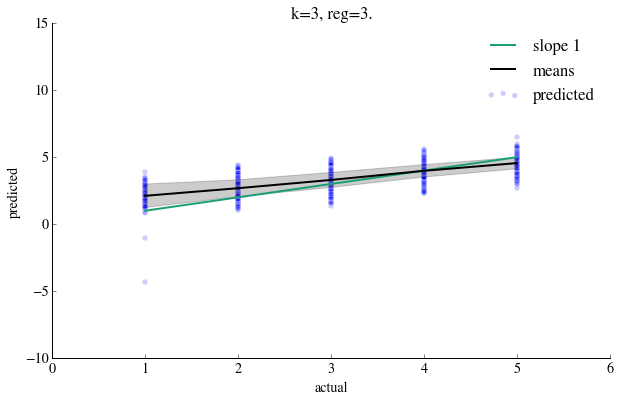

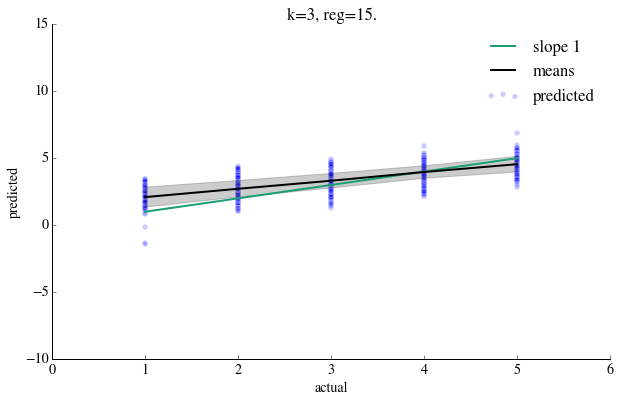

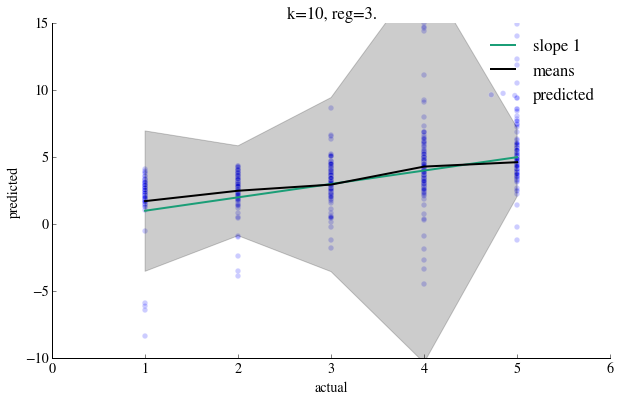

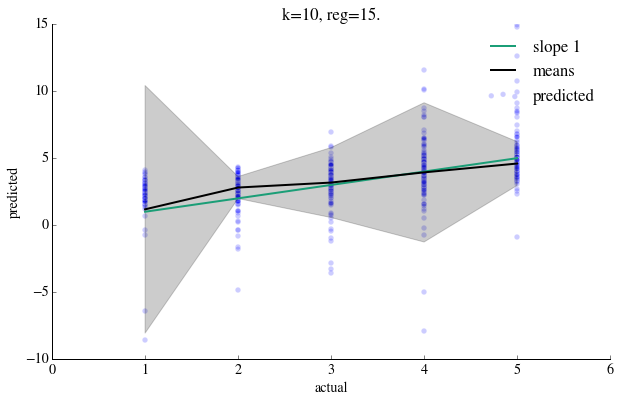

In [87]:
print "k=3, reg=3."
make_results_plot(smalldf,3,3.)
plt.title("k=3, reg=3.")

print "k=3, reg=15."
make_results_plot(smalldf,3,15.,)
plt.title("k=3, reg=15.")

print "k=10, reg=3."
make_results_plot(smalldf,10,3.)
plt.title("k=10, reg=3.")

print "k=10, reg=15."
make_results_plot(smalldf,10,15.,)
plt.title("k=10, reg=15.")

Pour **k=3**, les valeurs prédites sont relativement cohérentes, à l'exception de quelques prédictions qui ont de très grandes amplitudes. Il apparaît que les valeurs prédites tendent vers la note moyenne qui est d'environs 3.8, ce qui nous permet de dire que les notes faibles sont un peu surestimées, de façon similaire les notes élevés sont sous-estimées. La "régularisation" semble ne pas avoir un effet important pour un k = 3. 

Pour **k=10**, les valeurs prédites ne sont pas très stables avec beaucoup de notes extrêmes. Les moyennes prédites semblent en phase avec les notes moyennes réelles. La "régularisation" a un effet bien plus fort, même si indirect, sur l'apparence des graphes. Etant donnée que la régularisation a un effet plus fort sur les similarités entre les restaurants qui ont un "common support" faible, on peut voir qu'augmenter k fait que les prédictions sont bien plus sensible à la régularisation étant que dans un dataset petit, le "common support" entre un restaurant et ses 10 plus proches voisins sera faible.

Il faut noter que cette exemple ne semble pas suivre le tradeoff biais-variance standard, ici on voit qu'un petit k nous donne des estimations non biaisées qui mettent en valeur les extremes et qu'un grand k nous donne des estimations biaisées qui font tendre les valeurs extremes vers la moyenne. Une raison expliquant cela serait que l'on a définit un score de similarité qui peut être positif ou négatif alors que dans le biais-variance est fondé sur l'idée que l'on doit faire la moyenne des valeurs strictement positives. Quand on dispose de valeurs négatives, il est possible que la somme de $s_{ij}$ dans un voisinage soit proche de 0, faisant en sorte que notre estimateur $\hat Y_{um}$ explose dans la direction positive ou négative étant donné que cela revient presque à diviser par presque 0. D'où pour ces restaurants où le dénominateur tend vers 0 (ce qui est probable lorsque le k est élevé) une instabilité des notes.

Ce problème est moins prononcé sur des grands datasets ou avec un petit k car les k plus proches restaurants ont très probablement une similarité positive dans avec le dataset actuel. Cependant, avec des petits datasets, on peut trouver que même avec un k relativement petit (dans ce cas, environs 10), il y a des similarités négatives dans le k voisinage qui font que l'estimateur est instable. Ce genre d'instabilité peut être beaucoup moins prononcé dans un grand dataset.

Les grandes "ailes" que l'on voit plus haut dans le graphe d'erreur sont dues aux petites valeurs du dénominateur dans la somme des similarités. 

En effet, l'idée même que le plus proche voisin doit nous amener à réfléchir sur la question des distances et ces dernières ne peuvent être négatives. Qui plus est, on ne pourrait pas utiliser des distances autre que celles induites par le coefficient de correlation dans le calcul des plus proches voisins (tel que la distance de Manhattan ou la similarité de Jacard).

On peut résoudre ce problème pour le cas du coefficient de pearson en passant à un intervalle de 0-1.

$$ \rho \rightarrow \frac{\rho+1}{2} $$.

Ceci ce traduit en un changement du shrunk :

$$ s \rightarrow \frac{s}{2} + \frac{f}{2} $$

où 

$$ f = \frac{N_{common}}{N_{common}+reg} $$

On note que la nouvelle quantité est en réalité une distance inversée, on continuera donc à la trié de façon décroissante.

In [88]:
def knearest_pos(restaurant_id, set_of_restaurants, dbase, k=7, reg=3.):
    """
    Given a restaurant_id, dataframe, and database, get a sorted list of the
    k most similar restaurants from the entire database.
    """
    similars=[]
    for other_rest_id in set_of_restaurants:
        if other_rest_id!=restaurant_id:
            sim, nc=dbase.get(restaurant_id, other_rest_id)
            ssim=shrunk_sim(sim, nc, reg=reg)
            similars.append((other_rest_id, ssim/2.0 + float(nc)/(float(nc)+reg), nc ))
    similars=sorted(similars, key=itemgetter(1), reverse=True)
    return similars[0:k]

def knearest_amongst_userrated_pos(restaurant_id, user_id, df, dbase, k=7, reg=3.):
    dfuser=df[df.user_id==user_id]
    bizsuserhasrated=dfuser.business_id.unique()
    return knearest_pos(restaurant_id, bizsuserhasrated, dbase, k=k, reg=reg)

In [89]:
def rating_pos(df, dbase, restaurant_id, user_id, k=7, reg=3.):
    mu=df.stars.mean()
    users_reviews=df[df.user_id==user_id]
    nsum=0.
    scoresum=0.
    nears=knearest_amongst_userrated_pos(restaurant_id, user_id, df, dbase, k=k, reg=reg)
    restaurant_mean=df[df.business_id==restaurant_id].business_avg.values[0]
    user_mean=users_reviews.user_avg.values[0]
    scores=[]
    for r,sold,nc in nears:
        s=sold/2.0
        shrink_factor=float(nc)/(float(nc)+reg)
        s=s+shrink_factor/2.0
        scoresum=scoresum+s
        scores.append(s)
        r_reviews_row=users_reviews[users_reviews['business_id']==r]
        r_stars=r_reviews_row.stars.values[0]
        r_avg=r_reviews_row.business_avg.values[0]
        rminusb=(r_stars - (r_avg + user_mean - mu))
        nsum=nsum+s*rminusb
    baseline=(user_mean +restaurant_mean - mu)
    #we might have nears, but there might be no commons, giving us a pearson of 0
    if scoresum > 0.:
        val =  nsum/scoresum + baseline
    else:
        val=baseline
    return val

In [90]:
def make_results_plot_pos(df,k,reg):
    uid=smalldf.user_id.values
    bid=smalldf.business_id.values
    actual=smalldf.stars.values
    predicted=np.zeros(len(actual))
    counter=0
    for user_id, biz_id in zip(uid,bid):
        predicted[counter]=rating_pos(smalldf, db, biz_id, user_id, k=k, reg=reg) 
        counter=counter+1
    compare_results(actual, predicted, ylow=1, yhigh=5)

IMPORTANT : Quand on compare les graphes on note que les limites ont changé pour rendre la comparaison biais-variance plus visible. Le paramètre de régularisation est défini à 1 pour réduire la régularisation à quelque chose de petit, au lieu de quelque chose d'optimal. Pour tester des valeurs plus extremes on va choisir un k=15 à la place de k=10.

k=2, reg=1.
fraction between -15 and 15 rating 1.0
k=2, reg=15.
fraction between -15 and 15 rating 1.0
k=15, reg=1.
fraction between -15 and 15 rating 1.0
k=15, reg=15.
fraction between -15 and 15 rating 1.0


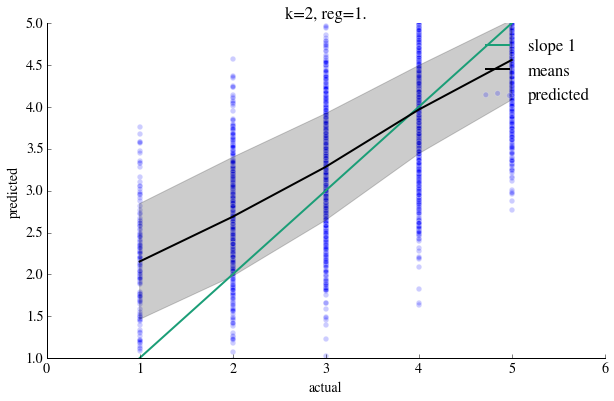

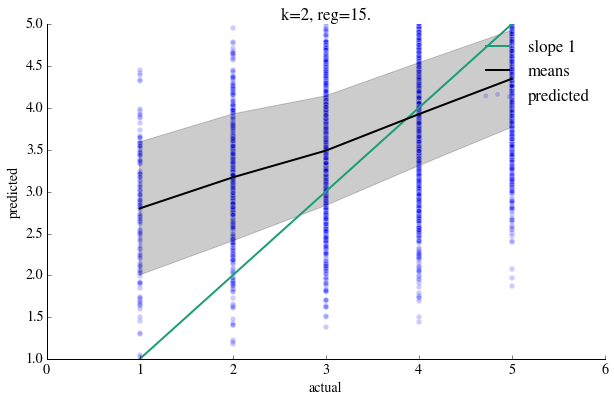

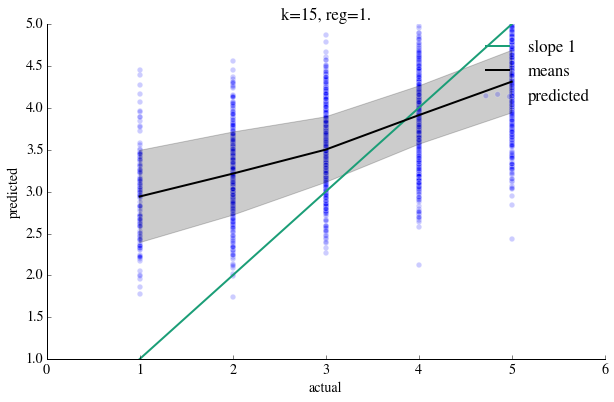

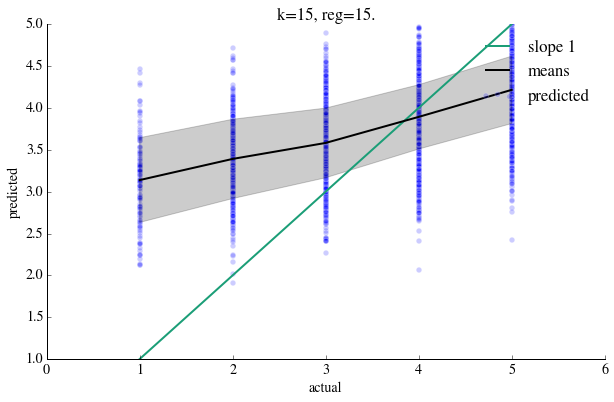

In [91]:
print "k=2, reg=1."
make_results_plot_pos(smalldf,2,1.)
plt.title("k=2, reg=1.")

print "k=2, reg=15."
make_results_plot_pos(smalldf,2,15.,)
plt.title("k=2, reg=15.")

print "k=15, reg=1."
make_results_plot_pos(smalldf,15,1.)
plt.title("k=15, reg=1.")

print "k=15, reg=15."
make_results_plot_pos(smalldf,15,15.,)
plt.title("k=15, reg=15.")

Premièrement, on remarque qu'une régularisation faible avec un k faible (variance limit) fait que la prédiction suit plus souvent la ligne verte que lorsque le k est élevé (bias limit). Ceci, comme mentionné précédement, est du la limite du biais ramenant les groupes de notes extrêmes vers la moyenne de toutes les critiques. Notons qu'augmenter le biais diminue la variation **entre** les groupes de notes permettant ainsi d'obtenir une courbe noire plus intéressante.

La seconde remarque relève que si le k augmente, la précision tel que mesurée par l'épaisseur de la région gris (qui mesure la variance **dans** les groupes de notes, non pas entre eux) devient petite.

Troisièmement, on remarque est qu'en ajoutant la régularisation dans la variance (k faible) limite augmente le biais, ce qui n'est pas une surprise car cela pousse les valeurs vers le centre. Dans beaucoup de problèmes de machine learning cette situation est souhaitée car elle diminue les risques de surapprentissage. Le biais limite élevé, comme prévu, n'a pas beaucoup d'impact. Notons que la régularisation a plus d'impact dans les précédents graphes étant donné quelle a poussé la similarité vers 0.

**2.5** On va expliciter le processus nous amenant à choisir le paramètre `k` des plus proches voisins. On va utiliser un paramètre de régularisation `reg` = 3.

On peut utiliser une $F$-fold cross-validation (normalement appelé $k$-fold cross-validation, mais nous avons déjà utilisé $k$). Plus précisément, on peut partitionner aléatoirement les données en $F$ échantillons de taille similaire, en s'assurant que chaque échantillon inclus au moins une note pour chaque restaurant et une note donnée par utilisateur (il serait probablement mieux de s'assurer que si $K$ est le $k$ maximum, on considèrerait que chaque utilisateur et chaque restaurant apparaît au moins $K$ fois dans chaque échantillons). Pour chaque valeur de $k$ et pour chaque échantillon, on peut répéter la procédure précédente pour prédire les notes données par l'utilisateur en calculant les similarités en utilisant $F-1$ échantillons. On peut ensuite choisir le $k$ avec la plus petite erreur de prédiction moyenne dans tous les échantillons et on recalcule la recommandation sur tout le dataset en utilisant cette valeur de $k$.

Si on souhaitait à la fois choisir une bonne valeur pour $k$ et vérifier la capacité du résultat à être généraliser, on pourrait diviser le dataset en $F+1$ échantillons et garder le dernier échantillon comme un set de vérification. On pourrait réaliser la cross-validation précédente sur $F$ échantillons pour sélectionner $k$, ensuite on pourrait utiliser tous les $F$ échantillons pour créer un générateur de recommandation.

## III.  Modèle bayésien : "Model based recommendations"

###Model-Based Recommandations


####Différence entre les procédures d'inférences "Frequentist" et Bayésienne

Dans la partie précédente, nous avons implémenté une **procédure** (une suite d'instructions pour processer de la donnée) pour donner des recommandations et prédire les notes des utilisateurs pour un restaurant. Cette procédure a impliqué un grand nombre de choix arbitraires -- par exemple, la mesure de similarité entre restaurants, la procédure de pondération pour contruire une note prédite, et on ne donnait aucune mesure de l'incertitude -- lorsqu'on devait donner des recommandations, on avait aucun moyen de comparer le classement fait par notre programme vis à vis de l'opinion de l'utilisateur quand aux restaurants et on avait aucun intervalle de confiance pour notre prédiction.

Il est possible qu'en répétant plusieurs fois la procédure précédente, on puisse voir quelles sont ses performances sur le long terme. En se basant sur cette perfomance à long terme, on peut probablement justifier certains de nos choix arbitraires et calculer une mesure d'incertitude. 

La stratégie de proposer une procédure dans un premier temps et ensuite d'évaluer ses performances dans la réalité ou en répétant artificiellement l'expérience est un parfait exemple de l'approche *frequentist* à un problème. Un aspect de l'approche *frequentist* est que la procédure proposée n'a pas forcément besoin de dériver d'un modèle (même si souvent c'est le cas). Même si cela signifie qu'une procédure empirique peut être plus flexible qu'une procédure basée sur un modèle, cela signifie aussi qu'il n'y a aucun schéma de travail qui justifierait certains choix fonctionnels ou  pour construire des estimations d'incertitudes.

A l'inverse, l'approche bayésienne commence toujours par un **modèle probabiliste** pour cerner comment la donnée est générée. En supposant que ce modèle est vrai, la distribution a posteriori que l'on va obtenir à propos de quantités inconnues (ou des paramètres qui doivent être estimés ou des données inconnues qu'il faut prédire) nous donne une seule expression cohérente décrivant nos données pour nous permettre de constuire des estimations et de réaliser des prédictions. En utilisant une distribution a posteriori, on peut aussi donner une idée de l'incertitude qu'on est sur le point d'estimer ou de la prédiction que l'on a construit.

####Construction de ce problème

Dans cette partie, on va construire un **modèle** décrivant comment les notes sont générées et utiliser ce modèle pour construire un système de recommandation et de prédiction des notes. Ici, on va utiliser une approche bayésienne pour construire nos estimations et nos prédictions depuis la distribution a posteriori, qui va être calculer en utilisant le *l'échantillonneur de Gibbs*. On va aussi donner des mesures d'incertitudes basées sur la distribution a posteriori. On va évaluer la prédiction de cette approche de la même façon avec laquelle on évalue la prédiction du KNN précédent.

###Le modèle à facteurs latents###

####Vue d'ensemble du modèle####

L'idée centrale quand on construit un système de recommandation utilisant le filtrage collaboratif est que *les utilisateurs similaires notent des restaurants similaires*. Dans la section précédente, on a explicitement implémenté cette idée en utilisant la fonction de similarité pour identifier les restaurants similaires. On a aussi supposé que soit tous les utilisateurs sont les mêmes (l'approche globale) ou que seul l'utilisateur actuel était suffisamment similaire pour faire une recommandation (l'approche "user-specific"). Dans cette partie, on va utiliser un modèle qui nous permet d'identifier à la fois les utilisateurs similaires et les restaurants similaires comme une fonction de **facteurs latents**.

On peut voir les facteurs latents comme des propriétés des restaurants (i.e. la teneur en épice de la nourriture ou le prix) qu'un utilisateur va préférer ou non. On n'observe pas ces facteurs ou les préférences de l'utilisateur directement, mais on suppose que cela a un effet sur la façon de noter des utilisateurs. Par exemple, si un restaurant sert beaucoup de nourritures épicés et qu'un utilisateur n'aime pas la nourriture épicé, alors le restaurant à un facteur "épice" élevé et l'utilisateur aurait une préférence très négative, ce qui permettra de prédire une note faible. Il faut noter que si les utilisateurs ont des préférences similaires, alors d'après le modèle, ils vont se comporter de façon similaire et si des restaurants ont des facteurs latents similaires, ils vont être noter de façon similaire par des utilisateurs similaires. Les facteurs latents nous fournissent une façon intuitive pour mettre en place un modèle qui obéit à l'idée centrale.

Un problème qui apparaît avec les modèles à facteurs latents est de déterminer combien de facteurs latents il faut inclure. Il peut y avoir plusieurs propriétés différentes non mesurées qui ont un effet sur les notes de différentes façons -- par exemple, en plus du niveau d'épices, il peut aussi y avoir un facteur prix qui influence comment les utilisateurs notent un restaurant. On résoud ce problème de choix du nombre de facteurs latents de la même façon que lorsqu'on choisit le $K$ pour le $K$NN.

####Spécification du modèle de notation####

Pour mettre en place ce modèle, on peut écrire notre modèle de probabilité comme un processus génératif. On définit dans un premier temps les valeurs suivantes :

Valeurs :

* $L$: Le nombre de facteurs latents.

* $U$: Le nombre d'utilisateurs.

* $M$: Le nombre de restaurants.

* $N$: Le nombre de notes/critiques.

Data:

* $Y_{um}$: La note donnée à un restaurant $m$ par un utilisateur $u$.

* $Y$: La collection complète des notes/critiques réalisées.

Quantités spécifiques au restaurant:

* $\gamma_m$: Un paramètre spécifique au restaurant représenter par un vecteur de taille $L+1$. Le premier élément de $\gamma_m$, noté $\gamma_m[0]$ est le biais spécifique à un restaurant. Le dernier élément $L$ de $\gamma_m$, noté $\gamma_m[1:]$, sont les facteurs latents associés avec le restaurant $m$.

* $\Gamma$: Une matrice $M$ par $L+1$ où la $m$ième ligne est $\gamma_m$.

Quantités spécifiques à l'utilisateur:

* $\theta_u$: Un paramètre spécifique à l'utilisateur représenter par un vecteur de taille $L+1$. Le premier élément de $\theta_u$, noté $\theta_u[0]$ est le biais spécifique à l'utilisateur. Le dernier élément $L$ de $\theta_u$, noté $\theta_u[1:]$, sont les facteurs latents associés à l'utilisateur $u$.

* $\Theta$: Une matrice $U$ par $L+1$ où la $u$ième ligne est $\theta_u$.

Quantités globales:

* $\mu$: La moyenne générale des notes.

* $\sigma$: La variance résiduelle des notes après que la moyenne, le biais et les facteurs latents ont été pris en compte.

En utilisant ces valeurs, on peut spécifier ce modèle pour chaque note $Y_{um}$ de façon similaire à une régression linéaire :

$$Y_{um} = \mu + \theta_{u}[0] + \gamma_{m}[0] + \theta_{u}[1:]^{\top}\gamma_{m}[1:] + \epsilon_{um}$$

où

$$\epsilon_{um} \sim N(0, \sigma).$$

On note que même si ceci ressemble à une régression linéaire, il s'agit de quelque chose de différent car le facteur latent nécessite le produit de deux inconnues.

On suppose aussi ces deux paramètres respectivement spécifiques à l'utilisateur et au restaurant :

$$
\begin{align*}
\gamma_m &\sim MVN(\mathbf 0, \Lambda_\gamma^{-1})\\
\theta_u &\sim MVN(\mathbf 0, \Lambda_\theta^{-1}),
\end{align*}
$$

où $MVN$ signifie "means multivariate normal", $\mathbf 0$ est un vecteur de taille $L+1$ rempli de zeros, $\Lambda_\theta^{-1}$ et $\Lambda_\gamma^{-1}$ sont des matrices de covariance de taille $L+1 \times L+1$.

#### But de ce modèle####

En utilisant ce modèle, on souhaite inférer sur les toutes les quantités qui, si on les connaissait, nous permettraient d'échantillonner $Y_{um}$ pour n'importe lequel des utilisateurs ou des restaurants. Ces quantités sont $\mu$, $\sigma$ et les éléments de $\Theta$ et $\Gamma$.

**3.1** Etant donnée le but que l'on s'est fixé plus haut, combien de valeurs (on compte un vecteur de $L$ restaurant comme $L$ valeurs) on est en train d'inférer ? 

Il y a $$U \times (L+1) + M \times (L+1) + 2$$ valeurs à estimer.

###Echantillonnage de Gibbs###

Notre but est de calculer la **distribution a posteriori** en utilisant les inconnues $\mu$, $\sigma$, $\Gamma$ et $\Theta$ sachant $Y$ qui représente notre connaissance de ces valeurs vis à vis des données dont on dispose. On exprime cette distribution tel que $P(\mu, \sigma, \Gamma, \Theta \mid Y)$.

La façon la plus commune pour apprendre à connaître la distribution a posteriori est de l'échantillonner. Ceci peut être difficile, particulièrement pour des problèmes avec des dimensions élevés. Une stratégie pour échantillonner des distributions à dimension élevé est l'**échantillonnage de Gibbs**.

L'échantillonnage de Gibbs consiste à découper la probabilité de distribution a posteriori en des groupes d'inconnues et d'échantillonner chaque groupe en supposant que les valeurs des autres groupes sont connues et fixées. Dans notre cas, on va découper la distribution a posteriori en groupe de $\mu$, $\sigma$, chaque vecteur $\gamma_m$et chaque vecteur $\theta_u$.


####Distribution de $\gamma_{m'}$ sachant $Y, \mu, \sigma, \Gamma_{-m'}, \Theta$####

Intuitivement, ceci est une distribution des paramètres spécifiques d'un restaurant pour un restaurant $m'$ et imaginons que toutes les autres inconnues sont fixées.

Plus précisement, on souhaite extraire de la distribution de $\gamma_{m'}$ en se basant sur les données de $Y$, ainsi que les inconnues que sont $\mu$, $\sigma$, tout $\Theta$, tout $\Gamma$ sauf $\gamma_{m'}$, que l'on note $\Gamma_{-m}$.

Il faut noter que dans les spécifications du modèle précédent, la seule place où $\gamma_{m'}$ apparait est l'équation de régression pour chaque $Y_{um}$ qui implique le restaurant $m'$. Si on écrit ces équations, on obtient le système d'équations suivant :

$$Y_{um'} = \mu + \theta_{u}[0] + \gamma_{m'}[0] + \theta_{u}[1:]^{\top}\gamma_{m'}[1:] + \epsilon_{um'},$$

avec une équation pour chaque $u$ qui a noté un restaurant $m'$. 

Si on déplace tous les termes connus à gauche, on obtient le système :

$$Y_{um'} - \mu - \theta_{u}[0] = \gamma_{m'}[0] + \theta_{u}[1:]^{\top}\gamma_{m'}[1:] + \epsilon_{um'}.$$

On remarque qu'étant donné que l'on suppose que $\theta_{u}$ est connue, cette équation ressemble à une régression linéaire où $\gamma_{m'}$ est un vecteur de coefficients inconnues. Cela signifie que la distribution a posteriori pour $\gamma_{m'}$ conditionnée par tout le reste est la même que la distribution a posteriori pour les coefficients d'une régression linéaire bayésienne de $(Y_{um'} - \mu - \theta_{u}[0])$ on $\theta_{u}[1:]$ et un "intercept".

Considérons le set d'utilisateurs qui ont noté le restaurant $m'$ tel que $(u_1, \cdots, u_g)$. On peut maintenant définir le vecteur suivant et la matrices suivante. 

\begin{align*}
Y_{m'} = \left(\begin{array}{c} Y_{u_1m'}-\mu-\theta_{u_1}[0]\\ \vdots \\ Y_{u_gm'}-\mu-\theta_{u_g}[0]\end{array}\right), \qquad
X_{m'} &= \left(\begin{array}{cc} 1 & \theta_{u_1}[1:]^\top \\ \vdots & \vdots \\ 1 & \theta_{u_g}[1:]^\top\end{array}\right),
\end{align*}

où $Y_{m'}$ est un vecteur de taille $g$ et $X_{m'}$ est une matrice $g \times L+1$.

Le tirage de $\gamma_{m'}$ sachant tout le reste se présente comme suit :

$$ \gamma_{m'} \mid Y, \mu, \sigma, \Gamma_{-m'}, \Theta \sim MVN\left(Q_{m'}^{-1} \frac{1}{\sigma^2}X_{m'}^\top Y_{m'}, Q_{m'}^{-1}\right)$$
où
$$ Q_{m'} = \left(\frac{1}{\sigma^2}X_{m'}^\top X_{m'} + \Lambda_\gamma\right).$$

#### Distribution de $\theta_{u'}$ sachant $Y, \mu, \sigma, \Gamma, \Theta_{-u'}$####

Intuitivement, ceci est une distribution des paramètres spécifiques d'un utilisateur pour un utilisateur $u'$ et imaginons que toutes les autres inconnues sont fixées.

On considère ici aussi un set de restaurant notés par un utilisateur $u'$ tel que $u'$ tel que $(m_1, \cdots, m_g)$ et on définit le vecteur et la matrice suivant :

\begin{align*}
Y_{u'} = \left(\begin{array}{c} Y_{u'm_1}-\mu-\gamma_{m_1}[0] \\ \vdots \\ Y_{u'm_g}-\mu-\gamma_{m_g}[0]\end{array}\right), \qquad
X_{u'} &= \left(\begin{array}{cc} 1 & \gamma_{m_1}[1:]^\top \\ \vdots & \vdots \\ 1 & \gamma_{m_g}[1:]^\top\end{array}\right),
\end{align*}

où $Y_{u'}$ est un vecteur de taille $g$ et $X_{u'}$ est une matrice $g \times L+1$.

Le tirage de $\theta_{u'}$ sachant tout le reste se présente comme suit :

$$ \theta_{u'} \mid Y, \mu, \sigma, \Gamma, \Theta_{-u'} \sim MVN\left(Q_{u'}^{-1} \frac{1}{\sigma^2}X_{u'}^\top Y_{u'}, Q_{u'}^{-1}\right)$$
où
$$ Q_{u'}= \left(\frac{1}{\sigma^2}X_{u'}^\top X_{u'} + \Lambda_\theta\right).$$

**3.2** Ici on implémente l'échantillonneur de Gibbs, ci-dessous la fonction qui implémente les tirages conditionnels a posteriori pour $\gamma_m$ and $\theta_u$.

In [92]:
"""
Function
--------
gamma_m_draw

Draw a single sample from the conditional posterior distribution
of gamma_m.

Inputs
-------
X_m: A g-by-L+1 matrix, defined above. 
Y_m: A 1D vector of length g, defined above.
sig2: Residual _variance_, as defined above.
Lambda_gamma: Prior precision matrix.

Outputs
--------
Single draw from conditional posterior, defined above.
"""
#Item-specific parameters given all else
#your code here
def gamma_m_draw(X_m, Y_m, sig2, Lambda_gamma):

    #Compute matrices that define conditional posterior.
    Q_m_inv = np.linalg.inv(np.dot(X_m.T, X_m)/sig2+Lambda_gamma)
    XtY = np.dot(X_m.T, Y_m)

    #Draw item-specific parameters.
    return np.random.multivariate_normal(np.dot(Q_m_inv, XtY)/sig2, Q_m_inv)

In [93]:
"""
Function
--------
theta_u_draw

Draw a single sample from the conditional posterior distribution
of gamma_m.

Inputs
-------
X_u: A g-by-L+1 matrix, defined above. 
Y_u: A 1D vector of length g, defined above.
sig2: Residual _variance_, as defined above.
Lambda_theta: Prior precision matrix.

Outputs
--------
Single draw from conditional posterior, defined above.
"""
#User-specific parameters given all else
#your code here
def theta_u_draw(X_u, Y_u, sig2, Lambda_theta):
    #Compute matrices that define conditional posterior.
    Q_u_inv = np.linalg.inv(np.dot(X_u.T, X_u)/sig2+Lambda_theta)
    XtY = np.dot(X_u.T, Y_u)
    
    #Draw the user-specific parameters
    return np.random.multivariate_normal(np.dot(Q_u_inv, XtY)/sig2, Q_u_inv)

Ici on présente le squelette de l'échantillonneur de Gibbs. L'échantillonneur itère sur $\mu$, $\sigma$, $\gamma_m$ pour chaque restaurant, et $\theta_u$ pour chaque utilisateur.

In [94]:
"""
Function
--------
factor_gibbs

Runs a gibbs sampler to infer mean, variance, user-specific, and item-specific
parameters.

Inputs
-------
data: A dataframe containing ratings data.
L: Dimension of latent factors.
maxit: Number of samples to draw from posterior.
Lambda_theta_diag: Hyperparameter controlling regularization of Theta.
Lambda_gamma_diag: Hyperparameter controlling regularization of Gamma.
progress: if true, print iteration number every 100 iterations.

Outputs
--------
Dictionary with elements
mu: Draws of mu. 1D array of length maxiter.
sig2: Draws of sig2, residual _variance_. 1D array of length maxiter.
theta: Draws of Theta. U-by-L-by-maxiter array.
gamma: Draws of Gamma. M-by-L-by-maxiter array.
EY: Draws of fitted values of Y. N-by-maxiter array.
"""
def factor_gibbs(data, L, maxit, Lambda_theta_diag, Lambda_gamma_diag, progress=True):
    data = data.copy()
    N = data.shape[0]

    #Create indices that allow us to map users and restaurants to rows
    #in parameter vectors.
    uusers, uidx = np.unique(data.user_id, return_inverse=True)
    uitems, midx = np.unique(data.business_id, return_inverse=True)

    nusers = uusers.size
    nitems = uitems.size

    #Add numerical indices to dataframe.
    data["uidx"] = uidx
    data["midx"] = midx

    #Group observations by user and by business.
    ugroups = data.groupby("uidx")
    mgroups = data.groupby("midx")

    all_avg = data.stars.mean()
    u_avg = ugroups.stars.mean()
    m_avg = mgroups.stars.mean()

    #Initialize parameters and set up data structures for
    #holding draws.
    #Overall mean
    mu = all_avg
    mu_draws = np.zeros(maxit)
    #Residual variance
    sig2 = 0.5
    sig2_draws = np.zeros(maxit)

    #Matrix of user-specific bias and L latent factors.
    theta = np.zeros([nusers, L+1])
    theta[:,0] = u_avg-all_avg
    theta_draws = np.zeros([nusers, L+1, maxit])

    #Matrix of item-specific bias and L latent factors.
    gamma = np.zeros([nitems, L+1])
    gamma[:,0] = m_avg-all_avg
    gamma_draws = np.zeros([nitems, L+1, maxit])

    #Matrix for holding the expected number of stars
    #for each observation at each draw from the posterior.
    EY_draws = np.zeros([data.shape[0], maxit])

    #Inverse covariance matrices from the prior on each theta_u
    #and gamma_b. These are diagonal, like Ridge regression.
    Lambda_theta = np.eye(L+1)*Lambda_theta_diag
    Lambda_gamma = np.eye(L+1)*Lambda_gamma_diag

    #Main sampler code
    for i in range(maxit):
        if i%100==0 and progress:
            print i

        #The entire regression equation except for the overall mean.
        nomu = np.sum(theta[data.uidx,1:]*gamma[data.midx,1:], axis=1) +\
                  theta[data.uidx,0] + gamma[data.midx,0]

        #Compute the expectation of each observation given the current
        #parameter values.
        EY_draws[:,i]=mu+nomu

        #Draw overall mean from a normal distribution
        mu = np.random.normal(np.mean(data.stars-nomu), np.sqrt(sig2/N))
        #Draw overall residual variance from a scaled inverse-Chi squared distribution.
        sig2 = np.sum(np.power(data.stars-nomu-mu,2))/np.random.chisquare(N-2)
        
        #For each item
        for mi,itemdf in mgroups:
            #Gather relevant observations, and subtract out overall mean and
            #user-specific biases, which we are holding fixed.
            Y_m = itemdf.stars-mu-theta[itemdf.uidx,0]
            #Build the regression design matrix implied by holding user factors
            #fixed.
            X_m = np.hstack((np.ones([itemdf.shape[0],1]),
                             theta[itemdf.uidx,1:]))
            gamma[mi,:] = gamma_m_draw(X_m, Y_m, sig2, Lambda_gamma)
            
        #For each user
        for ui,userdf in ugroups:
            #Gather relevant observations, and subtract out overall mean and
            #business-specific biases, which we are holding fixed.
            Y_u = userdf.stars-mu-gamma[userdf.midx,0]
            #Build the regression design matrix implied by holding business factors
            #fixed.
            X_u = np.hstack((np.ones([userdf.shape[0],1]),
                             gamma[userdf.midx,1:]))
            
            theta[ui,:] = theta_u_draw(X_u, Y_u, sig2, Lambda_theta)

        #Record draws
        mu_draws[i] = mu
        sig2_draws[i] = sig2
        theta_draws[:,:,i] = theta
        gamma_draws[:,:,i] = gamma

    return {"mu": mu_draws, "sig2": sig2_draws,
            "theta": theta_draws, "gamma": gamma_draws,
            "EY": EY_draws}

###Résultat a posteriori###

Dès que l'on a les tirages a posteriori depuis l'échantillonneur, la chose la plus naturelle à faire est de calculer la **moyenne a posteriori** de chaque quantité à laquelle on s'intéresse. Pour faire ça, on a besoin de prendre la valeur moyenne de chaque quantité tirée des échantillons par l'échantillonneur. Avant de prendre la moyenne, on souhaite ignorer 20-30% des premiers échantillons car ils correspondent à la **burnin period**, la période durant laquelle l'échantillonneur est encore en train de chercher la plus grande partie de la distribution.

**3.3** Maintenant que l'on dispose de 1000 échantillons extraient par l'échantillonneur de Gibbs depuis la distribution a posteriori en utilisant un facteur latent bidimensionnel et les précisions `Lambda_theta_diag` et `Lambda_gamma_diag` toutes deux égales à 0.1.

On va calculer la moyenne a posteriori des valeurs fitter pour chaque $Y_{um}$ en éliminant les 200 premiers échantillons, on va appeler cela la `prediction`. C'est ce qui va constituer notre recommandation.

In [95]:
gibbs_out = factor_gibbs(smalldf, 2, 1000, 0.1, 0.1)
burnin = 200
predicted=np.mean(gibbs_out['EY'][:,burnin:], axis=1)

0
100
200
300
400
500
600
700
800
900


On va dessiner le graphe des prédictions et des données observées en réalité. On va utiliser la fonction `compare_results` définie dans la partie précédente.

fraction between -15 and 15 rating 1.0


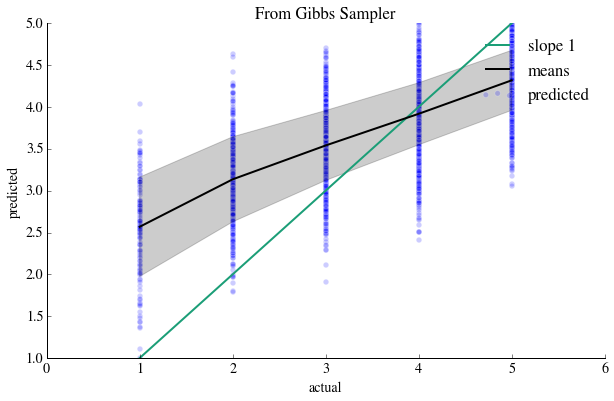

In [96]:
compare_results(smalldf.stars.values, predicted, ylow=1, yhigh=5, title="From Gibbs Sampler")

Les résultats provenant du modèle à facteur latent semble mieux se comporter que ceux fournis par le KNN (avec des similarités négatives) étant donnée qu'il n'y a aucune valeurs aberrantes. En terme de valeurs non-aberrantes fournit pas le KNN, le modèle à facteur latent semble faire des prédictions similaires aux KNN quand k = 3. Plus précisément, la ligne de prédiction moyenne pour chaque classe converge trop vers la moyenne totale des données 3.8, ce qui signifie que nous sommes dans la limite du biais où on concentre trop d'information entre chaque note. Ce qui nous amène à trop prédire des notes faibles et prédire trop peu de notes élevés.

(Si on compare au KNN avec des poids strictement positifs, comme plus bas, on voit que le système de recommandation fait des prédictions comparables, même si le modèle de facteur latent semble fitter mieux que les limites du biais et de la variance du KNN)

Il y a aussi un tradeoff biais-variance ici. Dans ce cas, il semble que nous avons proposé un modèle qui est trop simple (donc plus proche de la limite du biais) ce qui s'explique par comment les notes sont rapporchées vers la moyenne générale. En proposant plus de facteurs latents on augmente la flexibilité du modèle et donc on se déplace vers la variance limite. Par exemple, en considérant modèle à facteurs latents avec plus de facteurs (soit $L = 15$) pour obtenir un meilleur fit.

0
100
200
300
400
500
600
700
800
900
fraction between -15 and 15 rating 1.0


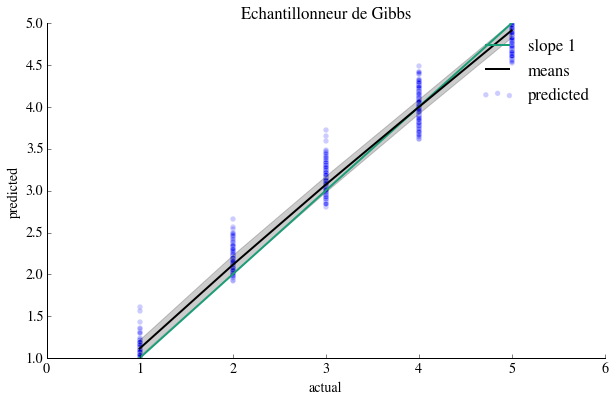

In [97]:
gibbs_out = factor_gibbs(smalldf, 15, 1000, 0.1, 0.1)
burnin = 200
predicted=np.mean(gibbs_out['EY'][:,burnin:], axis=1)
compare_results(smalldf.stars.values, predicted, ylow=1, yhigh=5, title="Echantillonneur de Gibbs")

Le fit ici semble plus intéressant, que ce soit pour le suivi de la ligne verte et en terme de précision (tel que mesurée par la bande grise). Un modèle à la variance limite (un qui serait très difficile à overfitter) avec un biais très faible va avoir une ligne des moyennes qui suit exactement la ligne verte et une zone grise presque inexistante.

##IV. Scaling Up

Tous les systèmes de recommandation souffre du fait que nous avons extrait une partie du dataset original qui est une matrice utilisateur-restaurant déjà très parcimonieuse. Plus on a de restaurant, plus on trouvera de restaurant dans le voisinage d'un restaurant précis et donc on sera plus à même de donner une note moyenne plus intéressante à un restaurant précis.

Dans cette partie, on va utiliser Map-Reduce pour traiter tout la matrice utilisateur-restaurant. On va faire ça en deux partie, dans un premier temps on va utiliser MrJob en local sur notre machine avec un petit dataset pour calculer la BDD de Pearson, puis dans un second temps on va traiter le dataset en entier sur un serveur Amazon. 

Le dataset complet dispose de 35000 utilisateurs et de 4500 restaurants. Calculer une matrice de similarité 4500x4500 sur une machine serait presque impossible. On va donc adopter la stratégie map-reduce avec des mappers et des reducers qui travaillent sur plusieurs machines.

Puis on calcule les KNN dans l'espace de l'utilisateur, cela implique une lecture de la BDD et une iteration sur chaque restaurant que l'utilisateur a noté.

On va dans un premier temps créer un subset des dataframes qui ont juste les colonnes que l'on souhaite envoyer à map-reduce. On va aussi enlever les header et l'index du tableau.

In [98]:
subsetoffull=fulldf[['user_id','business_id', 'stars','business_avg','user_avg']]
subsetoffull.to_csv("subset-full.csv", index=False, header=False)
subsetofsmall=smalldf[['user_id','business_id', 'stars','business_avg','user_avg']]
subsetofsmall.to_csv("subset-small.csv", index=False, header=False)

### Faire tourner mrJob en local

Les scripts `mrjob` ne peuvent pas tourner dans un ipython notebook. On va donc simplement les afficher ici.

Pour installer `mrjob`, il suffit de faire dans votre terminal : `pip install mrjob`
    
Pour écrire un script `mrjob`, on a lu la documentation http://mrjob.readthedocs.org/en/latest/guides/quickstart.html#writing-your-first-job.

Notre script s'inspire de la section "Writing your second job" de la documentation. 

Toutes les tâches mrjob utilise le paradigme map-reduce pour distribuer le calcul sur plusieurs machines. Le processus peut être décrit comme suit :

1. Pendant la première étape map, mrjob appelle un fonction mapper avec une clé (qui est None dans une première étape) et une valeur (qui est une ligne de donnée dans le fichier d'entrée). Cette fonction fait tout ce quelle veut de cette donnée et renvoie une clé et une valeur. La clé est utilisé dans l'étape 2 pour réunir les valeurs de tous les différents mappers dans des groupes.

2. mrjob collecte les résultats de tous les mappers et les réunit dans des subsets avec la même clé valeur (fonction similaire à un groupby). Il passe ensuite chacun de ces subsets dans un reducer dont le rôle est d'aggréger cette liste de donnée groupées en quelque chose d'intéressant (par ex: calculer la moyenne de toutes les entrées). Cela renvoi une clé et une valeur réduite.

3. S'il y a des étapes supplémentaires, mrjob renvoie le résultat du reducer de l'étape 2 dans un autre mapper. Sinon, il affiche le résultat.

####Ecriture de notre script

**4.1** On écrit un script appelé `computesim.py`. L'objet du script est de prendre un fichier CSV et de retourner un tuple `(rho, n_common)` comme un `calculate_similarity` pour des paires de restaurants.

Le script doit être utilisé dans le terminal comme suit :

    ~/anaconda/bin/python computesim.py subset-small.csv > output.small.local.txt

Quand le script est lu de cette façon cela va permettre à mrjob de lire ligne par ligne subset-small.csv et de passer chaque ligne dans la première étape.

####Algorithme pour calculer les similarités de Pearson

Ici on décrit notre algorithme pour calculer les similarités des restaurants.

On va passer par deux étapes, chaque étape dispose d'un mapper et d'un reducer. 

1. `line_mapper` va diviser la ligne et retourner le `user_id` comme une clé et le reste comme valeur.

2. `users_items_collector` est un reducer. Il prend en entrer tout ce que renvoie les mappers et qui correspondent à un `user_id` particulier. On va mettre les résultats des mappers dans des listes et on va renvoyer les `users_id` avec cette liste.

3. `pair_items_mapper` prend le `user_id`et la liste. Cela ne fait rien avec le `user_id`, cependant, cela prend toutes les combinaisons (donc len(list) égale 2) de 2 `business_id` de la liste en entrée et renvoie le reste des informations en tant que clé d'un tuple `(restaurant1, restaurant2)`. On s'est assuré de prendre en compte le cas où les ids du restaurant sont inversées, dans ce cas on les utilise comme deux mêmes clés.

4. `calc_sim_collector` reçoit toutes les listes précédentes, celle ci vont arriver de différents `user_id`. Cette liste d'informations devrait correspondre à tout les "common support" des deux restaurants. On va utiliser cette information pour calculer le common support et la similarité de pearson. On retourner le tuple en retournant sa clé avec le tuple de restaurants. Cette information va être retourner dans le fichier de sortie, les clés et valeurs renvoyées seront au format JSON séparé par une tabulation.

Le fichier de sortie s'appellera `output.small.local.txt`

In [100]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
from IPython.display import HTML
import urllib
skelcode = open("skeleton.py").read()
skelhtml=highlight(skelcode, PythonLexer(), HtmlFormatter())
HTML(skelhtml)

Les fonctions plus haut font de la rétention garde les valeurs sans les retourner. Il s'agit de **générateurs**. Voici un exemple :

In [101]:
def upper_generator(words):
    for word in words:
        yield word.upper()

words = ['a', 'couple', 'of', 'words', 'to', 'process']

print upper_generator(words)
print list(upper_generator(words))
for u in upper_generator(words):
     print u

<generator object upper_generator at 0x107965370>
['A', 'COUPLE', 'OF', 'WORDS', 'TO', 'PROCESS']
A
COUPLE
OF
WORDS
TO
PROCESS


In [102]:
thecode = open("computesim.py").read()
thehtml=highlight(thecode, PythonLexer(), HtmlFormatter())
HTML(thehtml)

#### Vérification des résultats

In [104]:
output_small_local=[[json.loads(j) for j in line.strip().split("\t")] for line in open("./output.small.local.txt")]
output_small_local[0]

[[u'-4A5xmN21zi_TXnUESauUQ', u'-AAig9FG0s8gYE4f8GfowQ'],
 [0.384365693729571, 5]]

On va implémenter une fonction `make_database_from_pairs` qui prend un dataframe de restaurants `smalldf` et le résultat de la commande précédente pour créer une base de données comme avant. Du fait du fonctionnement de map-reduce, celui-ci ne contient que les paires de restaurants avec un common support. Le constructeur `Database` initialise le reste des similarités à 0.

La fonction va prendre en entrée le dataframe et les `bizpairs` obtenues en parsant ce que nous renvoie Amazon Elastic Map Reduce (EMR) qui contient la clé des paires de restaurants et la valeur des paires de corrélation de pearson et `n_common`. Elle va retourner une instance de la classe `Database`.

Cette fonction prend beaucoup de temps pour tourner sur des grands datasets.

In [105]:
def make_database_from_pairs(df, bizpairs):
    """
    make the database from the pairs returned from mrjob.
    df is the dataframe, smalldf or fulldf.
    bizpairs are a list of elements, each of which is a list of two
        lists. The first of these lists has the two business id's, while
        the second has the similarity and the common support
    Returns an instance of the Database class.
    """
    dbase=Database(df)
    cache={}
    for bp,corrs in bizpairs:
        b1,b2=bp
        i1=dbase.uniquebizids[b1]
        i2=dbase.uniquebizids[b2]
        sim,nsup=corrs
        dbase.database_sim[i1][i2]=sim
        dbase.database_sim[i2][i1]=sim
        dbase.database_sup[i1][i2]=nsup
        dbase.database_sup[i2][i1]=nsup
        if cache.has_key(b1):
            nsup1=cache[b1]
        else:
            nsup1=dbase.df[dbase.df.business_id==b1].user_id.count()
            cache[b1]=nsup1
        if cache.has_key(b2):
            nsup2=cache[b2]
        else:
            nsup2=dbase.df[dbase.df.business_id==b2].user_id.count()
            cache[b2]=nsup2
        dbase.database_sim[i1][i1]=1.0
        dbase.database_sim[i2][i2]=1.0
        dbase.database_sup[i1][i1]=nsup1
        dbase.database_sup[i2][i2]=nsup2
    return dbase

On va stocker le résultat dans une variable `db_mrjob_local`.

In [106]:
db_mrjob_local=make_database_from_pairs(smalldf, output_small_local)

On affiche une paire pour voir que nos réponses sont identiques.

In [107]:
print db.get("zruUQvFySeXyEd7_rQixBg", "z3yFuLVrmH-3RJruPEMYKw")
print db_mrjob_local.get("zruUQvFySeXyEd7_rQixBg", "z3yFuLVrmH-3RJruPEMYKw")

(0.39904554525734559, 7)
(0.39904554525734548, 7)


**4.2** On teste que nos résultats sont relativement similaires à ceux que l'on a obtenue auparavant.

In [109]:
sums=0.
count=0
for k in db.uniquebizids.keys():
    for k2 in db.uniquebizids.keys():
        count=count+1
        sums=sums+db.get(k,k2)[0]-db_mrjob_local.get(k,k2)[0]
print sums
print count

-2.24265050974e-14
29584


###Test sur Amazon Elastic Map Reduce(EMR)

On va maintenant travailler sur Amazon EMR pour pouvoir traiter notre grand dataset.

#### Reproduire les résultats en utilisant le petit dataset sur EMR

On teste notre petit dataset pour voir si on obtient les mêmes résultats :

    ~/python computesim.py -r emr --num-ec2-instances 2 subset-small.csv > output.small.emr.txt

####Test du grand dataset

**4.3** On fait tourner le script sur le grand dataset `subset-full.csv`. On utilise entre 4 et 8 instances sur EMR. On enregistre le résultat dans `output.full.emr.txt`.

    ~/python computesim.py -r emr --num-ec2-instances 5 subset-full.csv > output.full.emr.txt

###Chargement de tout le résultat dans EMR

In [110]:
output_full_emr=[[json.loads(j) for j in l.strip().split("\t")] for l in open("./output.full.emr.txt")]

IOError: [Errno 2] No such file or directory: './output.full.emr.txt'

Cette fonction va prendre beaucoup de temps pour tourner (plus de 5 min, en fonction de l'ordinateur).

In [111]:
dbfull=make_database_from_pairs(fulldf, output_full_emr)

NameError: name 'output_full_emr' is not defined

**4.4**  On va encore une fois afficher les notes pour `testuserid` en utilisant les `bizs` liste d'avant. 

In [112]:
print "for user",usernamefromid(fulldf,testuserid), 'avg', fulldf[fulldf.user_id==testuserid].stars.mean() 
for i in bizs:
    print "========="
    print biznamefromid(fulldf, i), i
    print rating(fulldf, dbfull, i, testuserid, k=7, reg=3.) 
    u,a=get_other_ratings(i, testuserid, fulldf)
    print "User Score:",u,"Avg score",a

for user Vern avg 3.58227848101
Tee Pee Mexican Food soiGohHtWOltGeomkSxzEw


NameError: name 'dbfull' is not defined

Pour comparer voici les résultats du petit dataset :

    for user Vern avg 3.5652173913
    ----------------------------------
    Local Breeze
    Predicted Rating: 4.2280987611
    Actual User Rating: 5 Avg Rating 4.0
    ----------------------------------
    Carly's Bistro
    Predicted Rating: 3.99008654065
    Actual User Rating: 5 Avg Rating 3.5
    ----------------------------------
    Tee Pee Mexican Food
    Predicted Rating: 3.52640184162
    Actual User Rating: 5 Avg Rating 3.04347826087
    ----------------------------------
    District American Kitchen and Wine Bar
    Predicted Rating: 3.80281696528
    Actual User Rating: 4 Avg Rating 3.55263157895
    ----------------------------------
    Los Reyes de la Torta
    Predicted Rating: 3.41514298977
    Actual User Rating: 4 Avg Rating 4.13157894737

On peut remarquer que la note prédite en utilisant le grand dataset est bien plus proche de la note réelle obtenue. La raison expliquant cela est que l'on travaille toujours avec l'utilisateur Vern du set précédent, donc on choisit de travailler avec un utilisateur "prolifique" qui est susceptible d'avoir un voisinage très dense de restaurants dans le grand dataset.

On note que si on évaluait nos prédictions sur tout le dataset, au lieu de séléctionner les utilisateurs comme Vern, notre erreur de précision moyenne pourrait être plus élevée.

**4.5** On peut ajouter une autre étape dans la classe map-reduce de mrjob pour implémenter un système de recommandation simple, mais scalable, du type global comme vu dans les parties 1.4 à 1.6.

On peut ajouter une étape map additionnel et une étape reduce additionnel pour obtenir 1.5 et 1.6.

Etape MAP :
    
    def ranking_mapper(self, restaurants, values):
            sim, n_common = values
            rest1, rest2 = restaurants
            if int(n_common) > 0:
                yield (rest1), (sim, rest2, n_common)


Etape REDUCE :
        
        def top_similar_collector(self, key, values):
            rest1 = key
            for sim, rest2, n_common in sorted(values, reverse=True):
                yield None, (rest1, rest2, sim, n_common)
      
                
Code complet :

In [3]:
thecode = open("computesim2.py").read()
thehtml=highlight(thecode, PythonLexer(), HtmlFormatter())
HTML(thehtml)

NameError: name 'highlight' is not defined